This is a notebook that will be used to compare, select, tune, and analyze the best model for multilabel classification when predicting the best Emergency Support Functions (ESF) that would accompany a given set of features as selected by a user in our Streamlit user interface. It takes inputs of:
* State
* Region
* Declaration Type
* Designated Incident Type(s)

Our model will take these inputs and select the best ESFs that are commonly used in similar situations.

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import optuna
from functools import partial
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import warnings
from collected_functions import *


/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set base variable values

In [2]:
random_state = 42
np.random.seed(random_state)
cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}


Adjust Pandas settings to display more information before truncation.

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined MA and DDS training data

In [4]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
print(df.shape)
df.head()

(6765, 22)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,assistanceRequested,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day,AR_topic
0,2024081901,CT,Severe Storm,1,FOS,High,5.0,DOI-USGS,3612EMCTDOI-USGS01,EM,USGS Field measurements of flood-water heights...,"As directed by and in coordination with FEMA, ...",EM-3612-CT,Severe Storm,2024-08-18 00:00:00+00:00,9.0,"Severe Storm,Flood,Mud/Landslide","SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...",2024.0,8.0,18.0,28
1,2024072801,FL,Tropical Storm,4,FOS,Normal,8.0,VA,4806DRFLVA02,DR,Activate VHA OEM to NRCC ESF-8 PHMS. This is a...,As directed by and in coordination with FEMA a...,DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
2,2024072801,FL,Tropical Storm,4,FOS,Normal,0.0,VA,4806DRFLVA01,DR,Activate VA to NRCC. This is a re-issuance of ...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
3,2024072801,FL,Tropical Storm,4,FOS,Normal,4.0,USDA-FS,4806DRFLUSDA-FS01,DR,Activate USFS to the NRCC. This is a re-issuan...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,30
4,2024072801,FL,Tropical Storm,4,FOS,Normal,11.0,USDA-APH,4806DRFLUSDA-APH01,DR,"USDA liaison(s) to the NRCC, FEMA teams, or ot...","As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,32


Transform the training data set using approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [5]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year',
]

target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 6) 464
0           [7.0]
25          [7.0]
23          [7.0]
22          [7.0]
21    [11.0, 7.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2013020801,CT,Severe Storm,DR,1,2013.0
25,2014012201,OK,Severe Storm,DR,6,2013.0
23,2013122601,VT,Severe Ice Storm,DR,1,2013.0
22,2013111701,IL,Tornado,DR,5,2013.0
21,2013110101,SD,Severe Storm,DR,8,2013.0


In [6]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [7]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',
]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column,
    'ESF_'
)

In [8]:
#Drop year and incidentId from X_train_transformed.
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(464, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Run a variety of machine learning models and base classifiers using cross validation for model selection purposes.

In [10]:
# Create base classifiers for use with other models.
base_svc = SVC(
    gamma='auto',
    decision_function_shape='ovo',
    class_weight='balanced',
    random_state=random_state,
)
base_xgb = XGBClassifier(
    max_depth=12,
    random_state=random_state,
    n_estimators=100,
    base_score=0.5,
)
base_gnb = GaussianNB()

# Use some models from skmultilearn
br_classifier_svc = BinaryRelevance(
    classifier = base_svc,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_svc = ClassifierChain(
    classifier=base_svc, 
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_lr = ClassifierChain(
    classifier=LogisticRegression(max_iter=300),
    require_dense=[True, True],
)

# Check performance of sklearn models that can natively handle multiclass targets.
base_rf = RandomForestClassifier(
    random_state=random_state,
    n_jobs=-1,
    max_depth=12,
    n_estimators=100,
    class_weight='balanced_subsample'
)

base_etc = ExtraTreesClassifier(
    random_state=random_state,
    max_depth=12,
    n_jobs=-1,
    class_weight='balanced_subsample',
)

# Finish with sklearn models that require a base estimator.
moc_svc = MultiOutputClassifier(estimator=base_svc)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_svc = OneVsRestClassifier(estimator=base_svc)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

dummy = OneVsRestClassifier(DummyClassifier(strategy="stratified", random_state=random_state))


clf_list = [
    br_classifier_svc,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_svc,
    cc_classifier_xgb,
    cc_classifier_gnb,
    cc_classifier_lr,
    base_rf,
    base_etc,
    moc_svc,
    moc_xgb,
    moc_gnb,
    ovr_svc,
    ovr_xgb,
    ovr_gnb,
    dummy,
]

# Set up some scoring options that work well with multiclass results.
hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='samples', 
    zero_division=1,
)

# include mAP with the understanding that some of our models output sparse arrays which
# does not work in our scoring setup using cross_validate.
mean_average_precision = make_scorer(
    average_precision_score,
    average='macro', 
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'mAP':mean_average_precision,
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

BinaryRelevance(classifier=SVC(class_weight='balanced',
                               decision_function_shape='ovo', gamma='auto',
                               random_state=42),
                require_dense=[True, True])
Mean Hamming Loss: -0.28407696353436185, 0.027035385045262768

Mean F1 Macro Avg: 0.4790699085728334, 0.06427324405525425

Mean F1 Samples Avg: 0.5313052042144508, 0.013233745668489678

Mean Mean Average Precision: nan, nan
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         fe

XGBoost appears to be our best base model based on Hamming Loss and F1 scores, though SVC does beat it on F1 scores alone. The most promising models appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results and OneVsRestClassifier is more suited to this sort of task per documentation).

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier. We will be using Optuna for all models to keep outcomes consistent.

In [11]:
def objective_brxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    base_XGB = XGBClassifier(**xgb_params)
    
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

# Maximize the score to improve results
study_brxgb = optuna.create_study(direction="maximize")

study_brxgb.optimize(objective_brxgb,
                     n_trials=60,
                     show_progress_bar=True,
                     n_jobs=8,
                     )

print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 10:30:41,298] A new study created in memory with name: no-name-b6f40a44-8185-4f3f-8ce6-29e07f8c4c7e
Best trial: 3. Best value: 1.28055:   2%|▏         | 1/60 [00:02<02:39,  2.71s/it]

[I 2025-11-30 10:30:44,002] Trial 3 finished with value: 1.2805516833794333 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.07784624908416916, 'subsample': 0.6629118638322572, 'colsample_bytree': 0.6022013612845334, 'scale_pos_weight': 4.46833587252888}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:   3%|▎         | 2/60 [00:03<01:39,  1.72s/it]

[I 2025-11-30 10:30:45,030] Trial 4 finished with value: 1.2800708501095563 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.00016361701271047798, 'subsample': 0.763855382062222, 'colsample_bytree': 0.9089922082241157, 'scale_pos_weight': 2.272067653449346}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:   5%|▌         | 3/60 [00:04<01:24,  1.48s/it]

[I 2025-11-30 10:30:46,233] Trial 1 finished with value: 1.1743096147271461 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.00017415981448200453, 'subsample': 0.8735449842043396, 'colsample_bytree': 0.6072441897706576, 'scale_pos_weight': 5.452219897881576}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:   7%|▋         | 4/60 [00:05<00:55,  1.01it/s]

[I 2025-11-30 10:30:46,472] Trial 6 finished with value: 1.2573180216736295 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.00013763720970064828, 'subsample': 0.9071935120938208, 'colsample_bytree': 0.6662265725639481, 'scale_pos_weight': 4.404040244082931}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:   8%|▊         | 5/60 [00:06<00:56,  1.03s/it]

[I 2025-11-30 10:30:47,570] Trial 2 finished with value: 1.2751700319128125 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.07005981905188911, 'subsample': 0.6080567716225096, 'colsample_bytree': 0.6981551380453713, 'scale_pos_weight': 3.0097544412192914}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:  10%|█         | 6/60 [00:07<00:54,  1.01s/it]

[I 2025-11-30 10:30:48,536] Trial 5 finished with value: 1.2801290597564106 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.00506694907457422, 'subsample': 0.6481938036407355, 'colsample_bytree': 0.8866447211132059, 'scale_pos_weight': 3.2086436160986023}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:  12%|█▏        | 7/60 [00:07<00:39,  1.34it/s]

[I 2025-11-30 10:30:48,748] Trial 0 finished with value: 1.256839241993883 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.010589072955650498, 'subsample': 0.6170258103596029, 'colsample_bytree': 0.8286150325623137, 'scale_pos_weight': 5.298487113752371}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:  13%|█▎        | 8/60 [00:08<00:47,  1.10it/s]

[I 2025-11-30 10:30:49,988] Trial 11 finished with value: 1.234066573161229 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.07466488715248966, 'subsample': 0.8513004953523863, 'colsample_bytree': 0.7519077729528649, 'scale_pos_weight': 3.96780266786051}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:  15%|█▌        | 9/60 [00:09<00:47,  1.07it/s]

[I 2025-11-30 10:30:50,995] Trial 7 finished with value: 1.22766141792567 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.0017405836342100625, 'subsample': 0.732694735671567, 'colsample_bytree': 0.7464849619222437, 'scale_pos_weight': 5.843306211311395}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 3. Best value: 1.28055:  17%|█▋        | 10/60 [00:10<00:38,  1.29it/s]

[I 2025-11-30 10:30:51,415] Trial 8 finished with value: 1.2268357455258099 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.013147977175268616, 'subsample': 0.6619224649797226, 'colsample_bytree': 0.741346549881098, 'scale_pos_weight': 5.662292113767382}. Best is trial 3 with value: 1.2805516833794333.


Best trial: 10. Best value: 1.28442:  18%|█▊        | 11/60 [00:11<00:41,  1.19it/s]

[I 2025-11-30 10:30:52,393] Trial 10 finished with value: 1.2844224050890924 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.0012241198865818466, 'subsample': 0.7059616602097146, 'colsample_bytree': 0.9026078189450689, 'scale_pos_weight': 3.191423358677302}. Best is trial 10 with value: 1.2844224050890924.


Best trial: 10. Best value: 1.28442:  20%|██        | 12/60 [00:11<00:35,  1.37it/s]

[I 2025-11-30 10:30:52,883] Trial 13 finished with value: 1.2431240490589626 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.0003263074345515198, 'subsample': 0.9204052906950697, 'colsample_bytree': 0.8741078912907091, 'scale_pos_weight': 4.155428468353577}. Best is trial 10 with value: 1.2844224050890924.
[I 2025-11-30 10:30:52,884] Trial 9 finished with value: 1.2347349304526003 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.031143062299483486, 'subsample': 0.9462901941709008, 'colsample_bytree': 0.6923761297416149, 'scale_pos_weight': 3.864305787597716}. Best is trial 10 with value: 1.2844224050890924.


Best trial: 17. Best value: 1.29011:  23%|██▎       | 14/60 [00:12<00:23,  1.94it/s]

[I 2025-11-30 10:30:53,417] Trial 17 finished with value: 1.2901070840909536 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0009991286677646977, 'subsample': 0.7077483360965057, 'colsample_bytree': 0.6070055639181091, 'scale_pos_weight': 2.6105470668759496}. Best is trial 17 with value: 1.2901070840909536.


Best trial: 17. Best value: 1.29011:  25%|██▌       | 15/60 [00:12<00:19,  2.28it/s]

[I 2025-11-30 10:30:53,625] Trial 12 finished with value: 1.2858003228685102 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.011323312502151432, 'subsample': 0.8271580950122527, 'colsample_bytree': 0.8863411977206975, 'scale_pos_weight': 2.014082172204074}. Best is trial 17 with value: 1.2901070840909536.


Best trial: 18. Best value: 1.29367:  27%|██▋       | 16/60 [00:13<00:23,  1.88it/s]

[I 2025-11-30 10:30:54,422] Trial 18 finished with value: 1.2936680108074454 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0011121502265938584, 'subsample': 0.714226925614814, 'colsample_bytree': 0.8269981870112214, 'scale_pos_weight': 2.6319888117020467}. Best is trial 18 with value: 1.2936680108074454.


Best trial: 20. Best value: 1.29493:  28%|██▊       | 17/60 [00:13<00:23,  1.81it/s]

[I 2025-11-30 10:30:55,029] Trial 19 finished with value: 1.284049589128633 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.001122804099636863, 'subsample': 0.7054294476783807, 'colsample_bytree': 0.9470529814986939, 'scale_pos_weight': 2.5717882076865854}. Best is trial 18 with value: 1.2936680108074454.
[I 2025-11-30 10:30:55,059] Trial 20 finished with value: 1.2949313061582408 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0010405011955382263, 'subsample': 0.7050247385090215, 'colsample_bytree': 0.8199205509689281, 'scale_pos_weight': 2.5925997494210224}. Best is trial 20 with value: 1.2949313061582408.


Best trial: 21. Best value: 1.3038:  32%|███▏      | 19/60 [00:14<00:17,  2.36it/s] 

[I 2025-11-30 10:30:55,545] Trial 14 finished with value: 1.2660295122877212 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0036679768379243166, 'subsample': 0.6049251972254809, 'colsample_bytree': 0.8901821232955309, 'scale_pos_weight': 3.7016177586251366}. Best is trial 20 with value: 1.2949313061582408.
[I 2025-11-30 10:30:55,575] Trial 21 finished with value: 1.3038017807944968 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0009115329217530829, 'subsample': 0.7159598817293417, 'colsample_bytree': 0.8109356924443814, 'scale_pos_weight': 2.549091983648675}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  35%|███▌      | 21/60 [00:15<00:17,  2.18it/s]

[I 2025-11-30 10:30:56,572] Trial 23 finished with value: 1.267819698591873 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.0006286318575102216, 'subsample': 0.7800332052836074, 'colsample_bytree': 0.816024658634852, 'scale_pos_weight': 2.648967543657841}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  37%|███▋      | 22/60 [00:15<00:16,  2.31it/s]

[I 2025-11-30 10:30:56,913] Trial 22 finished with value: 1.27898915170742 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.0008625867558873961, 'subsample': 0.8225287302404511, 'colsample_bytree': 0.9488305358129617, 'scale_pos_weight': 2.194613000575823}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  38%|███▊      | 23/60 [00:15<00:15,  2.43it/s]

[I 2025-11-30 10:30:57,258] Trial 24 finished with value: 1.2853249431951406 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.0004874720409646923, 'subsample': 0.8002725576820467, 'colsample_bytree': 0.8085824169857141, 'scale_pos_weight': 2.597560208701083}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  42%|████▏     | 25/60 [00:17<00:16,  2.18it/s]

[I 2025-11-30 10:30:58,250] Trial 25 finished with value: 1.2715012353983381 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.0005317349955447934, 'subsample': 0.784309748390356, 'colsample_bytree': 0.8099901508882854, 'scale_pos_weight': 2.650218340507571}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:30:58,435] Trial 16 finished with value: 1.2593232756681914 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.0004738689055524611, 'subsample': 0.6482172810532579, 'colsample_bytree': 0.8107244877719116, 'scale_pos_weight': 3.3779633543654257}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  42%|████▏     | 25/60 [00:17<00:16,  2.18it/s]

[I 2025-11-30 10:30:58,488] Trial 15 finished with value: 1.2122261959817062 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.0953685963932396, 'subsample': 0.755479858553291, 'colsample_bytree': 0.9142753809103328, 'scale_pos_weight': 2.532925389944914}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  45%|████▌     | 27/60 [00:17<00:10,  3.09it/s]

[I 2025-11-30 10:30:58,722] Trial 26 finished with value: 1.2818854730043583 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.00047934318186858304, 'subsample': 0.7982299218267883, 'colsample_bytree': 0.8204222011756903, 'scale_pos_weight': 2.7457658173546755}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  47%|████▋     | 28/60 [00:17<00:11,  2.77it/s]

[I 2025-11-30 10:30:59,203] Trial 27 finished with value: 1.272552293790282 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.0004830321401043561, 'subsample': 0.8010957496231096, 'colsample_bytree': 0.8079227810704631, 'scale_pos_weight': 2.266381277329994}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  48%|████▊     | 29/60 [00:18<00:10,  2.82it/s]

[I 2025-11-30 10:30:59,534] Trial 28 finished with value: 1.2874888406396217 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.0003927490233572814, 'subsample': 0.755813712856892, 'colsample_bytree': 0.8128076901309942, 'scale_pos_weight': 2.289543348870382}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  50%|█████     | 30/60 [00:19<00:17,  1.73it/s]

[I 2025-11-30 10:31:00,744] Trial 29 finished with value: 1.286023287243605 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.00042764666541490797, 'subsample': 0.753390644691647, 'colsample_bytree': 0.814783103410186, 'scale_pos_weight': 2.849101971298703}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  52%|█████▏    | 31/60 [00:19<00:13,  2.08it/s]

[I 2025-11-30 10:31:00,965] Trial 30 finished with value: 1.2832955701906967 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.0019953813522139542, 'subsample': 0.749205297013922, 'colsample_bytree': 0.8515651220578637, 'scale_pos_weight': 2.8886345172804027}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  53%|█████▎    | 32/60 [00:20<00:15,  1.82it/s]

[I 2025-11-30 10:31:01,692] Trial 31 finished with value: 1.2776212230097284 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.002226022780445506, 'subsample': 0.7430537740269665, 'colsample_bytree': 0.8442990092208983, 'scale_pos_weight': 2.9102949254721633}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  57%|█████▋    | 34/60 [00:21<00:10,  2.38it/s]

[I 2025-11-30 10:31:02,245] Trial 32 finished with value: 1.288433173384639 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0020543006247138026, 'subsample': 0.7382944241800402, 'colsample_bytree': 0.8511333102762857, 'scale_pos_weight': 2.9496023577088586}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:02,347] Trial 33 finished with value: 1.2917428115164125 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.002309668561674929, 'subsample': 0.7350396849183994, 'colsample_bytree': 0.8533759698460819, 'scale_pos_weight': 2.940237474843154}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  60%|██████    | 36/60 [00:21<00:08,  2.77it/s]

[I 2025-11-30 10:31:02,844] Trial 34 finished with value: 1.282521002043928 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0022781005696410326, 'subsample': 0.7337099281884317, 'colsample_bytree': 0.7769936504236988, 'scale_pos_weight': 2.9332774466149485}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:03,010] Trial 38 finished with value: 1.288623249331862 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.0018248392899499317, 'subsample': 0.7008396149405082, 'colsample_bytree': 0.8463056657964365, 'scale_pos_weight': 2.3877533765284755}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  63%|██████▎   | 38/60 [00:22<00:07,  2.97it/s]

[I 2025-11-30 10:31:03,616] Trial 35 finished with value: 1.277641674010372 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0016752065780310744, 'subsample': 0.7308525551538254, 'colsample_bytree': 0.8587043680679534, 'scale_pos_weight': 2.9037048015362448}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:03,721] Trial 36 finished with value: 1.2822000313085926 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.00248314352741509, 'subsample': 0.6884267426942373, 'colsample_bytree': 0.8486055475302593, 'scale_pos_weight': 2.8972787731608958}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  65%|██████▌   | 39/60 [00:22<00:05,  3.70it/s]

[I 2025-11-30 10:31:03,837] Trial 39 finished with value: 1.2768272395490503 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.004838625088470814, 'subsample': 0.6976149994597259, 'colsample_bytree': 0.7836973715140967, 'scale_pos_weight': 2.0490844072036185}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  67%|██████▋   | 40/60 [00:23<00:08,  2.37it/s]

[I 2025-11-30 10:31:04,613] Trial 40 finished with value: 1.3012812612249407 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.005537410309362494, 'subsample': 0.7008537644011139, 'colsample_bytree': 0.777340697248319, 'scale_pos_weight': 2.462921865896163}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  68%|██████▊   | 41/60 [00:24<00:10,  1.82it/s]

[I 2025-11-30 10:31:05,465] Trial 37 finished with value: 1.281091509543172 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0022314651976266106, 'subsample': 0.6849649556040266, 'colsample_bytree': 0.8533930130826939, 'scale_pos_weight': 2.0405437673585247}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  70%|███████   | 42/60 [00:25<00:12,  1.50it/s]

[I 2025-11-30 10:31:06,412] Trial 43 finished with value: 1.2283054081092897 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.00023204750100493782, 'subsample': 0.6809193979327608, 'colsample_bytree': 0.7844814871655417, 'scale_pos_weight': 3.1764469328796547}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  72%|███████▏  | 43/60 [00:25<00:09,  1.79it/s]

[I 2025-11-30 10:31:06,716] Trial 44 finished with value: 1.2837375620070972 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.006468164117800825, 'subsample': 0.688829078404678, 'colsample_bytree': 0.7817500087071846, 'scale_pos_weight': 3.1602121194194415}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  73%|███████▎  | 44/60 [00:25<00:08,  1.78it/s]

[I 2025-11-30 10:31:07,280] Trial 41 finished with value: 1.2579997570846744 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.005096272154232622, 'subsample': 0.7142522884258755, 'colsample_bytree': 0.780750770120531, 'scale_pos_weight': 5.048126698152213}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:07,282] Trial 42 finished with value: 1.280171353519579 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.003658716354513592, 'subsample': 0.7141636294849397, 'colsample_bytree': 0.7692380727713919, 'scale_pos_weight': 2.3597799672513227}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  77%|███████▋  | 46/60 [00:27<00:07,  1.84it/s]

[I 2025-11-30 10:31:08,323] Trial 48 finished with value: 1.2798511900417366 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.0002234343438958852, 'subsample': 0.6301097142092772, 'colsample_bytree': 0.7860191607081792, 'scale_pos_weight': 2.436370404777539}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  78%|███████▊  | 47/60 [00:27<00:06,  1.96it/s]

[I 2025-11-30 10:31:08,729] Trial 50 finished with value: 1.2764771037885922 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.007793298332160564, 'subsample': 0.7190691721193158, 'colsample_bytree': 0.7376982902051791, 'scale_pos_weight': 2.467834745136666}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  82%|████████▏ | 49/60 [00:27<00:04,  2.72it/s]

[I 2025-11-30 10:31:08,960] Trial 45 finished with value: 1.2760239193168892 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.00025371241773957195, 'subsample': 0.6839537809165478, 'colsample_bytree': 0.7864002003015739, 'scale_pos_weight': 3.214950949455312}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:09,145] Trial 49 finished with value: 1.276103698334018 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.007271082083795145, 'subsample': 0.6345448989654682, 'colsample_bytree': 0.7601501801853952, 'scale_pos_weight': 2.4300542659935926}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 21. Best value: 1.3038:  82%|████████▏ | 49/60 [00:27<00:04,  2.72it/s]

[I 2025-11-30 10:31:09,194] Trial 46 finished with value: 1.2726067223067439 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.00022598740030556572, 'subsample': 0.6726310244678341, 'colsample_bytree': 0.7912264820398935, 'scale_pos_weight': 2.391853613057549}. Best is trial 21 with value: 1.3038017807944968.


Best trial: 52. Best value: 1.31016:  85%|████████▌ | 51/60 [00:28<00:03,  2.49it/s]

[I 2025-11-30 10:31:10,031] Trial 47 finished with value: 1.252564533997722 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.00025981769899599484, 'subsample': 0.6754933900739619, 'colsample_bytree': 0.7131776537094413, 'scale_pos_weight': 5.024815383180082}. Best is trial 21 with value: 1.3038017807944968.
[I 2025-11-30 10:31:10,125] Trial 52 finished with value: 1.3101592823204242 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.024952001761939752, 'subsample': 0.6658207749278942, 'colsample_bytree': 0.713477197532359, 'scale_pos_weight': 2.4217926365338345}. Best is trial 52 with value: 1.3101592823204242.


Best trial: 52. Best value: 1.31016:  90%|█████████ | 54/60 [00:29<00:01,  3.47it/s]

[I 2025-11-30 10:31:10,507] Trial 51 finished with value: 1.296624018250902 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.022359220866210366, 'subsample': 0.6366896624578517, 'colsample_bytree': 0.7226102116864376, 'scale_pos_weight': 2.4536409630696814}. Best is trial 52 with value: 1.3101592823204242.
[I 2025-11-30 10:31:10,615] Trial 53 finished with value: 1.278939050570877 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.00843626246847395, 'subsample': 0.6679858127894241, 'colsample_bytree': 0.8334394919025903, 'scale_pos_weight': 2.139639123116489}. Best is trial 52 with value: 1.3101592823204242.


Best trial: 52. Best value: 1.31016:  93%|█████████▎| 56/60 [00:29<00:01,  3.64it/s]

[I 2025-11-30 10:31:11,081] Trial 56 finished with value: 1.2688052281742574 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.0007669632741346985, 'subsample': 0.6664384405324251, 'colsample_bytree': 0.7302422803949612, 'scale_pos_weight': 2.1656231072862075}. Best is trial 52 with value: 1.3101592823204242.
[I 2025-11-30 10:31:11,190] Trial 57 finished with value: 1.2501229223374453 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.00074739797413734, 'subsample': 0.6655430215138642, 'colsample_bytree': 0.7211645236026953, 'scale_pos_weight': 3.55831869873896}. Best is trial 52 with value: 1.3101592823204242.


Best trial: 52. Best value: 1.31016:  97%|█████████▋| 58/60 [00:30<00:00,  4.48it/s]

[I 2025-11-30 10:31:11,423] Trial 55 finished with value: 1.2628516596994017 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.0008164492497792584, 'subsample': 0.669244285404411, 'colsample_bytree': 0.8354166137402569, 'scale_pos_weight': 2.1629584223859597}. Best is trial 52 with value: 1.3101592823204242.
[I 2025-11-30 10:31:11,542] Trial 59 finished with value: 1.2766784881097695 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.020435795356061395, 'subsample': 0.6559926166459983, 'colsample_bytree': 0.7258989884816313, 'scale_pos_weight': 2.157095849081583}. Best is trial 52 with value: 1.3101592823204242.


Best trial: 52. Best value: 1.31016:  98%|█████████▊| 59/60 [00:30<00:00,  5.28it/s]

[I 2025-11-30 10:31:11,645] Trial 58 finished with value: 1.274993046342575 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0008156978826176724, 'subsample': 0.7252958414791913, 'colsample_bytree': 0.6212312460050506, 'scale_pos_weight': 2.7011749234697975}. Best is trial 52 with value: 1.3101592823204242.


Best trial: 52. Best value: 1.31016: 100%|██████████| 60/60 [00:30<00:00,  1.94it/s]

[I 2025-11-30 10:31:12,162] Trial 54 finished with value: 1.281060634763573 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.03506029906386237, 'subsample': 0.6648889432860683, 'colsample_bytree': 0.833064600862625, 'scale_pos_weight': 2.1823374364859927}. Best is trial 52 with value: 1.3101592823204242.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.3102
Best Parameters:
  n_estimators: 75
  max_depth: 11
  learning_rate: 0.024952001761939752
  subsample: 0.6658207749278942
  colsample_bytree: 0.713477197532359
  scale_pos_weight: 2.4217926365338345


In [12]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


We see some rows with many false positives in the error heatmap, and we see that many of our predictions include too many labels and others too few.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering, which was an approach that we found while searching for recommendations for improving ClassifierChain outcomes.

In [13]:
# Make sure we have a type that works for our needs.
if isinstance(y_train_transformed, np.ndarray):
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))

# Assign label orders via correlation measures
correlation_matrix = Y_df.corr() 
num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

total_correlations = correlation_matrix.abs().sum(axis=1)
start_label = total_correlations.idxmax()
ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(1), 12, 10, 11, 2, 4, 6, 5, 8, 9, 13, 3, 0, 14, 15, 7]


We will use this label order in our tuning instance.

In [14]:
def objective_ccxgb(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order,
                        random_state=random_state
                        )

# 3. Create and Run the Optuna Study
study_ccxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ccxgb.optimize(objective_ccxgb,
                     n_trials=5,
                     show_progress_bar=True,
                     n_jobs=5,
                     )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 10:31:16,592] A new study created in memory with name: no-name-fdd25cc0-70ab-43c0-9cca-a90d3fcdc2ff
Best trial: 1. Best value: 0.646967:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

[I 2025-11-30 10:31:18,009] Trial 3 finished with value: 0.6176897085806845 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.002277390081935353, 'subsample': 0.7641876352985015, 'colsample_bytree': 0.8202218409046659, 'scale_pos_weight': 3.0703376197171974}. Best is trial 3 with value: 0.6176897085806845.
[I 2025-11-30 10:31:18,145] Trial 1 finished with value: 0.6469667831622898 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.0005284043172770431, 'subsample': 0.856202516921126, 'colsample_bytree': 0.9472969268521415, 'scale_pos_weight': 5.560465756657082}. Best is trial 1 with value: 0.6469667831622898.


Best trial: 0. Best value: 0.67272:  60%|██████    | 3/5 [00:02<00:01,  1.73it/s] 

[I 2025-11-30 10:31:18,621] Trial 0 finished with value: 0.6727196652788242 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.0021872486825234563, 'subsample': 0.9229319270113108, 'colsample_bytree': 0.7946744261400744, 'scale_pos_weight': 4.291047521923941}. Best is trial 0 with value: 0.6727196652788242.


Best trial: 0. Best value: 0.67272: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

[I 2025-11-30 10:31:20,155] Trial 4 finished with value: 0.5824121529431876 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.00022101043971827273, 'subsample': 0.6674145637191311, 'colsample_bytree': 0.6745539928752887, 'scale_pos_weight': 2.311390044508014}. Best is trial 0 with value: 0.6727196652788242.
[I 2025-11-30 10:31:20,311] Trial 2 finished with value: 0.6029421946103507 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0004423499957014215, 'subsample': 0.7137338374252372, 'colsample_bytree': 0.7782040647889447, 'scale_pos_weight': 2.36173916475805}. Best is trial 0 with value: 0.6727196652788242.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.6727
Best Parameters:
  n_estimators: 125
  max_depth: 7
  learning_rate: 0.0021872486825234563
  subsample: 0.9229319270113108
  colsample_bytree: 0.7946744261400744
  scale_pos_weight: 4.291047521923941


In [15]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. There also seem to be pockets of results based on some predicted label cardinality rows with no entries.

We will try one instance using the standard order for comparison.

In [16]:
def objective_ccxgb2(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=list(range(0,16)),
                        random_state=random_state
                        )

study_ccxgb2 = optuna.create_study(direction="maximize")

study_ccxgb2.optimize(objective_ccxgb2,
                      n_trials=60,
                      show_progress_bar=True,
                      n_jobs=8,
                      )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 10:31:25,394] A new study created in memory with name: no-name-0c3d95d5-dbe7-41ba-a8ea-743b87b6b746
Best trial: 5. Best value: 1.0104:   2%|▏         | 1/60 [00:01<01:46,  1.81s/it]

[I 2025-11-30 10:31:27,196] Trial 5 finished with value: 1.0103964986924172 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.026910413288003667, 'subsample': 0.6325726996948404, 'colsample_bytree': 0.9176221528180216, 'scale_pos_weight': 4.988414360503049}. Best is trial 5 with value: 1.0103964986924172.


Best trial: 7. Best value: 1.22603:   3%|▎         | 2/60 [00:02<01:13,  1.27s/it]

[I 2025-11-30 10:31:28,095] Trial 7 finished with value: 1.2260254273724618 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.07591464447583608, 'subsample': 0.7407897658936382, 'colsample_bytree': 0.8924087390854929, 'scale_pos_weight': 2.1267715227093245}. Best is trial 7 with value: 1.2260254273724618.


Best trial: 7. Best value: 1.22603:   5%|▌         | 3/60 [00:03<01:09,  1.21s/it]

[I 2025-11-30 10:31:29,238] Trial 3 finished with value: 1.14952137060858 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.08034258011408979, 'subsample': 0.6995482135801814, 'colsample_bytree': 0.8156659595359569, 'scale_pos_weight': 2.2059962106583786}. Best is trial 7 with value: 1.2260254273724618.


Best trial: 7. Best value: 1.22603:   7%|▋         | 4/60 [00:04<00:52,  1.07it/s]

[I 2025-11-30 10:31:29,744] Trial 6 finished with value: 1.1483370560327857 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.0018852383324636692, 'subsample': 0.9301907138661957, 'colsample_bytree': 0.8731825606443757, 'scale_pos_weight': 3.540127348653393}. Best is trial 7 with value: 1.2260254273724618.


Best trial: 7. Best value: 1.22603:  10%|█         | 6/60 [00:06<00:46,  1.15it/s]

[I 2025-11-30 10:31:31,559] Trial 4 finished with value: 1.1955554964087511 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.03274057735981578, 'subsample': 0.8694340214029443, 'colsample_bytree': 0.6013058396983413, 'scale_pos_weight': 3.9760935650242475}. Best is trial 7 with value: 1.2260254273724618.
[I 2025-11-30 10:31:31,687] Trial 0 finished with value: 1.1547081600272964 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.0001365220494711211, 'subsample': 0.9364662279166207, 'colsample_bytree': 0.6243861673758162, 'scale_pos_weight': 5.563738258115308}. Best is trial 7 with value: 1.2260254273724618.


Best trial: 8. Best value: 1.30835:  13%|█▎        | 8/60 [00:06<00:28,  1.85it/s]

[I 2025-11-30 10:31:32,148] Trial 2 finished with value: 1.2393391146163018 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.005127662823814532, 'subsample': 0.7678056127311874, 'colsample_bytree': 0.7887725211961598, 'scale_pos_weight': 2.6630701566159183}. Best is trial 2 with value: 1.2393391146163018.
[I 2025-11-30 10:31:32,274] Trial 8 finished with value: 1.3083515313014011 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.016523146002887276, 'subsample': 0.6518631760737159, 'colsample_bytree': 0.6005205325772309, 'scale_pos_weight': 2.3863633584442048}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  17%|█▋        | 10/60 [00:08<00:35,  1.42it/s]

[I 2025-11-30 10:31:34,191] Trial 9 finished with value: 1.2185934843780797 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.008827198076902954, 'subsample': 0.8279201364236837, 'colsample_bytree': 0.6065502001081724, 'scale_pos_weight': 4.542111043660525}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:34,298] Trial 1 finished with value: 1.2263435608076727 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.015485260230533373, 'subsample': 0.9465503986246842, 'colsample_bytree': 0.6841992182775175, 'scale_pos_weight': 2.515791417617412}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  22%|██▏       | 13/60 [00:11<00:32,  1.46it/s]

[I 2025-11-30 10:31:36,657] Trial 10 finished with value: 1.2404405258549922 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.029886217180679582, 'subsample': 0.6218218787846487, 'colsample_bytree': 0.7989036324916883, 'scale_pos_weight': 2.4959154320228225}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:36,735] Trial 12 finished with value: 1.2314935526247777 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.0005696649452193762, 'subsample': 0.678686969996412, 'colsample_bytree': 0.8972043998271308, 'scale_pos_weight': 2.9287390665308726}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:36,820] Trial 11 finished with value: 1.189080060932742 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.04670553777972155, 'subsample': 0.6863162443489311, 'colsample_bytree': 0.868598799692522, 'scale_pos_weight': 3.6354358592601654}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  23%|██▎       | 14/60 [00:12<00:33,  1.39it/s]

[I 2025-11-30 10:31:37,641] Trial 14 finished with value: 1.1907289705047908 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0030810073435907706, 'subsample': 0.8653193589389632, 'colsample_bytree': 0.774764783131258, 'scale_pos_weight': 3.924101735332574}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  25%|██▌       | 15/60 [00:12<00:29,  1.55it/s]

[I 2025-11-30 10:31:38,083] Trial 15 finished with value: 1.23775384245891 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0001121458344546191, 'subsample': 0.7893035039919585, 'colsample_bytree': 0.8686926067431316, 'scale_pos_weight': 3.1753079144605856}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  27%|██▋       | 16/60 [00:13<00:25,  1.73it/s]

[I 2025-11-30 10:31:38,481] Trial 17 finished with value: 1.2487963931322164 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.000921390738752124, 'subsample': 0.6361307874614309, 'colsample_bytree': 0.7032075639997575, 'scale_pos_weight': 2.942284958035755}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  28%|██▊       | 17/60 [00:13<00:25,  1.71it/s]

[I 2025-11-30 10:31:39,081] Trial 13 finished with value: 1.193932002233166 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.0667634093581118, 'subsample': 0.8308901766913813, 'colsample_bytree': 0.9186351340977724, 'scale_pos_weight': 5.3149805531894785}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  30%|███       | 18/60 [00:15<00:39,  1.07it/s]

[I 2025-11-30 10:31:40,900] Trial 18 finished with value: 1.2464925947981023 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0015320926912252622, 'subsample': 0.6043502348613423, 'colsample_bytree': 0.7141259713960588, 'scale_pos_weight': 2.9256237003166428}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  32%|███▏      | 19/60 [00:16<00:38,  1.05it/s]

[I 2025-11-30 10:31:41,876] Trial 21 finished with value: 1.2665809421620815 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01457027478125276, 'subsample': 0.6038465399091945, 'colsample_bytree': 0.7247571564130705, 'scale_pos_weight': 3.022282280440664}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  33%|███▎      | 20/60 [00:16<00:31,  1.27it/s]

[I 2025-11-30 10:31:42,266] Trial 16 finished with value: 1.187178371724361 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.0021893813939910713, 'subsample': 0.6053400678744051, 'colsample_bytree': 0.7552736464992139, 'scale_pos_weight': 5.732604474073444}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  35%|███▌      | 21/60 [00:17<00:24,  1.57it/s]

[I 2025-11-30 10:31:42,549] Trial 22 finished with value: 1.29206011615013 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.014943943550041763, 'subsample': 0.6025876285896903, 'colsample_bytree': 0.7253592397317957, 'scale_pos_weight': 2.4456448785795266}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  38%|███▊      | 23/60 [00:17<00:17,  2.17it/s]

[I 2025-11-30 10:31:42,991] Trial 23 finished with value: 1.2460889359729272 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0007845934687872478, 'subsample': 0.6034789735253914, 'colsample_bytree': 0.6902836847527315, 'scale_pos_weight': 2.0243026347928987}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:43,171] Trial 20 finished with value: 1.2578860244465888 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.0017707150187898813, 'subsample': 0.6007408723003025, 'colsample_bytree': 0.720618734458333, 'scale_pos_weight': 2.976604708758548}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  40%|████      | 24/60 [00:18<00:16,  2.22it/s]

[I 2025-11-30 10:31:43,599] Trial 24 finished with value: 1.2494681171601008 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0009323462281412431, 'subsample': 0.6010393490543201, 'colsample_bytree': 0.703456108537675, 'scale_pos_weight': 3.0328448744896535}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  42%|████▏     | 25/60 [00:18<00:16,  2.18it/s]

[I 2025-11-30 10:31:44,075] Trial 25 finished with value: 1.2032492292927466 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.0004930035720218809, 'subsample': 0.6508751086032718, 'colsample_bytree': 0.6600143760795876, 'scale_pos_weight': 2.35632386720311}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  43%|████▎     | 26/60 [00:18<00:13,  2.57it/s]

[I 2025-11-30 10:31:44,301] Trial 19 finished with value: 1.2622328319143719 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.0024541375835919243, 'subsample': 0.6021134281235163, 'colsample_bytree': 0.7107469325122734, 'scale_pos_weight': 3.0875371643888534}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  45%|████▌     | 27/60 [00:19<00:17,  1.91it/s]

[I 2025-11-30 10:31:45,142] Trial 26 finished with value: 1.2266670070155608 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.010931393390061099, 'subsample': 0.6631766130874583, 'colsample_bytree': 0.6578121192678777, 'scale_pos_weight': 2.2751635203366836}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  47%|████▋     | 28/60 [00:20<00:17,  1.81it/s]

[I 2025-11-30 10:31:45,765] Trial 27 finished with value: 1.230348053082047 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01246473270425085, 'subsample': 0.6632998188319594, 'colsample_bytree': 0.6555958355981187, 'scale_pos_weight': 2.240545770591679}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  48%|████▊     | 29/60 [00:20<00:14,  2.15it/s]

[I 2025-11-30 10:31:46,022] Trial 28 finished with value: 1.2521021102459038 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.012001964847438703, 'subsample': 0.6584551758021608, 'colsample_bytree': 0.6582731900039323, 'scale_pos_weight': 2.3704858699177853}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  50%|█████     | 30/60 [00:21<00:13,  2.18it/s]

[I 2025-11-30 10:31:46,466] Trial 29 finished with value: 1.251381555579084 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.011422027371551114, 'subsample': 0.6585306892038932, 'colsample_bytree': 0.6596680105836111, 'scale_pos_weight': 2.298904171297535}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:46,468] Trial 30 finished with value: 1.2741200119793736 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01128032659105682, 'subsample': 0.6647738645316738, 'colsample_bytree': 0.6516736861597061, 'scale_pos_weight': 2.3054614973394436}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  53%|█████▎    | 32/60 [00:21<00:09,  2.99it/s]

[I 2025-11-30 10:31:46,847] Trial 31 finished with value: 1.2777246295972804 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.013038843091343991, 'subsample': 0.6622094185882034, 'colsample_bytree': 0.6318034637494523, 'scale_pos_weight': 2.3272669165220927}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  55%|█████▌    | 33/60 [00:21<00:08,  3.09it/s]

[I 2025-11-30 10:31:47,134] Trial 32 finished with value: 1.2593592450121462 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.009605631428361606, 'subsample': 0.665683801916601, 'colsample_bytree': 0.6446950666942388, 'scale_pos_weight': 2.63121337451662}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  57%|█████▋    | 34/60 [00:22<00:13,  1.92it/s]

[I 2025-11-30 10:31:48,216] Trial 33 finished with value: 1.283824300825638 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.011101277323743056, 'subsample': 0.6647295099766413, 'colsample_bytree': 0.6502757404902411, 'scale_pos_weight': 2.662276074451549}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  58%|█████▊    | 35/60 [00:23<00:14,  1.68it/s]

[I 2025-11-30 10:31:49,008] Trial 39 finished with value: 1.2512714521063082 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.00623920912954382, 'subsample': 0.7166898494254816, 'colsample_bytree': 0.6232422991773913, 'scale_pos_weight': 2.6528242991043522}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  60%|██████    | 36/60 [00:23<00:11,  2.04it/s]

[I 2025-11-30 10:31:49,230] Trial 40 finished with value: 1.2434283332449318 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.005481917433413997, 'subsample': 0.7149580834332802, 'colsample_bytree': 0.627702479429529, 'scale_pos_weight': 2.6770601918597743}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  62%|██████▏   | 37/60 [00:25<00:17,  1.32it/s]

[I 2025-11-30 10:31:50,657] Trial 41 finished with value: 1.2557650185506168 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.005063908067507301, 'subsample': 0.7143371783478233, 'colsample_bytree': 0.626916857752596, 'scale_pos_weight': 2.6919069535179245}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  63%|██████▎   | 38/60 [00:26<00:16,  1.32it/s]

[I 2025-11-30 10:31:51,416] Trial 34 finished with value: 1.2549555600259343 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.00559465505905534, 'subsample': 0.7403092444266066, 'colsample_bytree': 0.7371841458899042, 'scale_pos_weight': 2.6674710628436564}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:51,471] Trial 35 finished with value: 1.2482865319918055 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.004899608020015257, 'subsample': 0.7139003177661475, 'colsample_bytree': 0.7466533669255309, 'scale_pos_weight': 2.6640866397471554}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  68%|██████▊   | 41/60 [00:26<00:08,  2.26it/s]

[I 2025-11-30 10:31:51,991] Trial 38 finished with value: 1.2378719689007873 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.005629309463615283, 'subsample': 0.7164798935807123, 'colsample_bytree': 0.6328315883112443, 'scale_pos_weight': 2.6708132487062675}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:52,116] Trial 37 finished with value: 1.2446300340484648 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.005675520954786728, 'subsample': 0.718202541304135, 'colsample_bytree': 0.6330933467168519, 'scale_pos_weight': 2.6996233003634935}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  70%|███████   | 42/60 [00:27<00:07,  2.44it/s]

[I 2025-11-30 10:31:52,434] Trial 36 finished with value: 1.2559419489701837 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.0053094403645133955, 'subsample': 0.7129653641043131, 'colsample_bytree': 0.7479137288520668, 'scale_pos_weight': 2.740123149961023}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  72%|███████▏  | 43/60 [00:29<00:15,  1.10it/s]

[I 2025-11-30 10:31:54,707] Trial 43 finished with value: 1.2416370866990962 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.02841810728730536, 'subsample': 0.7017361456921817, 'colsample_bytree': 0.6259242093916291, 'scale_pos_weight': 2.0323977263878237}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:54,712] Trial 42 finished with value: 1.2673192536339262 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.019947953045370677, 'subsample': 0.7162362538779122, 'colsample_bytree': 0.6210602358839895, 'scale_pos_weight': 2.5119959515986015}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  75%|███████▌  | 45/60 [00:29<00:09,  1.57it/s]

[I 2025-11-30 10:31:55,259] Trial 45 finished with value: 1.2311485855817743 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.018943777803108516, 'subsample': 0.6281251531471876, 'colsample_bytree': 0.6041711996300131, 'scale_pos_weight': 2.002670684691652}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  78%|███████▊  | 47/60 [00:30<00:06,  1.94it/s]

[I 2025-11-30 10:31:55,968] Trial 46 finished with value: 1.2436425058606433 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.023162894478789536, 'subsample': 0.753427458147091, 'colsample_bytree': 0.679255729599324, 'scale_pos_weight': 2.478740100115093}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:56,081] Trial 47 finished with value: 1.2202604488817295 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.019013353435720047, 'subsample': 0.6410645114378819, 'colsample_bytree': 0.6816183444141681, 'scale_pos_weight': 2.080739555281035}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  80%|████████  | 48/60 [00:31<00:05,  2.09it/s]

[I 2025-11-30 10:31:56,454] Trial 48 finished with value: 1.237607158629008 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.019820168249411647, 'subsample': 0.6355906008790769, 'colsample_bytree': 0.6821309492970663, 'scale_pos_weight': 2.4598361817675003}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:56,540] Trial 44 finished with value: 1.2799951516162609 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.0195011376401151, 'subsample': 0.6278546871996273, 'colsample_bytree': 0.7418627261684364, 'scale_pos_weight': 2.024494175945929}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  83%|████████▎ | 50/60 [00:31<00:03,  2.99it/s]

[I 2025-11-30 10:31:56,744] Trial 49 finished with value: 1.275472509389416 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.019368937375612415, 'subsample': 0.6333427980868446, 'colsample_bytree': 0.6012764499207617, 'scale_pos_weight': 2.4458639833611486}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  85%|████████▌ | 51/60 [00:31<00:03,  2.80it/s]

[I 2025-11-30 10:31:57,175] Trial 50 finished with value: 1.267377299051208 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.018594556403088873, 'subsample': 0.628675974878073, 'colsample_bytree': 0.6004008681085645, 'scale_pos_weight': 2.4979946581637065}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  87%|████████▋ | 52/60 [00:32<00:03,  2.46it/s]

[I 2025-11-30 10:31:57,730] Trial 52 finished with value: 1.2619955706273964 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.020918556220048054, 'subsample': 0.6408767771933469, 'colsample_bytree': 0.6804964113141768, 'scale_pos_weight': 2.1537659064800967}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  88%|████████▊ | 53/60 [00:33<00:03,  1.89it/s]

[I 2025-11-30 10:31:58,598] Trial 53 finished with value: 1.2670055245792506 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.046426190057895535, 'subsample': 0.6419643036355168, 'colsample_bytree': 0.8270955075649044, 'scale_pos_weight': 2.160518936160178}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  93%|█████████▎| 56/60 [00:33<00:01,  3.59it/s]

[I 2025-11-30 10:31:58,839] Trial 54 finished with value: 1.257832074563544 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.041177118570524814, 'subsample': 0.6751775570813368, 'colsample_bytree': 0.6027547479603973, 'scale_pos_weight': 3.332219486678133}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:58,877] Trial 51 finished with value: 1.2679771576109518 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.020392255863072563, 'subsample': 0.6349747788128577, 'colsample_bytree': 0.6777231450204155, 'scale_pos_weight': 2.170055413416609}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:58,960] Trial 55 finished with value: 1.293983579295314 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.045284065153734517, 'subsample': 0.69464247273113, 'colsample_bytree': 0.8319274523125678, 'scale_pos_weight': 2.1399469673678837}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835:  98%|█████████▊| 59/60 [00:33<00:00,  5.32it/s]

[I 2025-11-30 10:31:59,179] Trial 56 finished with value: 1.256492277342207 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.0512862707221137, 'subsample': 0.6859193141750192, 'colsample_bytree': 0.8422920708086185, 'scale_pos_weight': 2.1570559522149795}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:59,180] Trial 57 finished with value: 1.2874351503189774 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.04329440234884361, 'subsample': 0.6809180222389178, 'colsample_bytree': 0.7685149917352819, 'scale_pos_weight': 2.1188371227621086}. Best is trial 8 with value: 1.3083515313014011.
[I 2025-11-30 10:31:59,332] Trial 58 finished with value: 1.258845070249666 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.04192128362535513, 'subsample': 0.6891484789914653, 'colsample_bytree': 0.7976011723500449, 'scale_pos_weight': 2.1605841555839618}. Best is trial 8 with value: 1.3083515313014011.


Best trial: 8. Best value: 1.30835: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]

[I 2025-11-30 10:31:59,520] Trial 59 finished with value: 1.2182685799209785 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.046134509276264064, 'subsample': 0.6828727567742577, 'colsample_bytree': 0.8446891906602896, 'scale_pos_weight': 2.1787562384620447}. Best is trial 8 with value: 1.3083515313014011.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.3084
Best Parameters:
  n_estimators: 175
  max_depth: 11
  learning_rate: 0.016523146002887276
  subsample: 0.6518631760737159
  colsample_bytree: 0.6005205325772309
  scale_pos_weight: 2.3863633584442048


In [17]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
    order=list(range(0,16)),
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. There are also still plenty of instances in which we underestimate the number of labels as well. Our BinaryRelevance model appears to be the best option so far.

The final hypertuning instance will be for OneVersusRest using XGBoost as our base estimator.

In [18]:
def objective_ovrxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The OneVsRestClassifier multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred)
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

study_ovrxgb = optuna.create_study(direction="maximize")

study_ovrxgb.optimize(objective_ovrxgb,
                      n_trials=60,
                      show_progress_bar=True,
                      n_jobs=8,
                      )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 10:32:08,689] A new study created in memory with name: no-name-8ad9a6f4-e660-4273-8d37-1e570a41d844
Best trial: 2. Best value: 1.2611:   2%|▏         | 1/60 [00:04<04:04,  4.15s/it]

[I 2025-11-30 10:32:12,817] Trial 2 finished with value: 1.2610962801296606 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.08930201860772304, 'subsample': 0.6983142549051271, 'colsample_bytree': 0.7012916162213696, 'scale_pos_weight': 3.2641944031972736}. Best is trial 2 with value: 1.2610962801296606.


Best trial: 2. Best value: 1.2611:   3%|▎         | 2/60 [00:08<04:10,  4.31s/it]

[I 2025-11-30 10:32:17,252] Trial 5 finished with value: 1.2394240762239648 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.00029667082008350985, 'subsample': 0.9030757338059318, 'colsample_bytree': 0.6835241502068363, 'scale_pos_weight': 4.1076006271117915}. Best is trial 2 with value: 1.2610962801296606.


Best trial: 2. Best value: 1.2611:   5%|▌         | 3/60 [00:10<03:15,  3.44s/it]

[I 2025-11-30 10:32:19,646] Trial 7 finished with value: 1.226187219635651 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.0007075207466311386, 'subsample': 0.8503203103120125, 'colsample_bytree': 0.9382833333211132, 'scale_pos_weight': 3.3570467034443996}. Best is trial 2 with value: 1.2610962801296606.


Best trial: 0. Best value: 1.26961:   8%|▊         | 5/60 [00:12<01:41,  1.85s/it]

[I 2025-11-30 10:32:21,460] Trial 0 finished with value: 1.2696124392298944 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.0023308833933649267, 'subsample': 0.6931216432256536, 'colsample_bytree': 0.8323360691659608, 'scale_pos_weight': 2.9824502694485813}. Best is trial 0 with value: 1.2696124392298944.
[I 2025-11-30 10:32:21,633] Trial 9 finished with value: 1.254003105792181 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.0003621148537648969, 'subsample': 0.7846041903101642, 'colsample_bytree': 0.8503209031615752, 'scale_pos_weight': 3.4997594466352204}. Best is trial 0 with value: 1.2696124392298944.


Best trial: 0. Best value: 1.26961:  10%|█         | 6/60 [00:13<01:24,  1.56s/it]

[I 2025-11-30 10:32:22,643] Trial 8 finished with value: 1.2596254074776405 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.007029660510448388, 'subsample': 0.6744344803797426, 'colsample_bytree': 0.8395393923905246, 'scale_pos_weight': 4.084263915259902}. Best is trial 0 with value: 1.2696124392298944.


Best trial: 0. Best value: 1.26961:  12%|█▏        | 7/60 [00:18<02:12,  2.50s/it]

[I 2025-11-30 10:32:27,071] Trial 3 finished with value: 1.2325050052549915 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.000395029089949926, 'subsample': 0.8672816987102409, 'colsample_bytree': 0.8502190580093065, 'scale_pos_weight': 3.7404355697383465}. Best is trial 0 with value: 1.2696124392298944.
[I 2025-11-30 10:32:27,266] Trial 6 finished with value: 1.2378143882125936 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0022494977132528674, 'subsample': 0.9473475855355299, 'colsample_bytree': 0.6217481345734573, 'scale_pos_weight': 4.31491879535611}. Best is trial 0 with value: 1.2696124392298944.


Best trial: 4. Best value: 1.2772:  15%|█▌        | 9/60 [00:19<01:22,  1.63s/it] 

[I 2025-11-30 10:32:28,585] Trial 4 finished with value: 1.2772000312447216 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.00024957951762212023, 'subsample': 0.6640947233895222, 'colsample_bytree': 0.9491291320274148, 'scale_pos_weight': 2.5376213967149845}. Best is trial 4 with value: 1.2772000312447216.


Best trial: 4. Best value: 1.2772:  17%|█▋        | 10/60 [00:20<01:03,  1.27s/it]

[I 2025-11-30 10:32:29,054] Trial 1 finished with value: 1.2393810982499227 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.015247507958837617, 'subsample': 0.8480821127612888, 'colsample_bytree': 0.9250643402734569, 'scale_pos_weight': 2.7929970424235098}. Best is trial 4 with value: 1.2772000312447216.


Best trial: 4. Best value: 1.2772:  18%|█▊        | 11/60 [00:22<01:08,  1.39s/it]

[I 2025-11-30 10:32:30,730] Trial 12 finished with value: 1.2245775074804417 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.00012091833130544262, 'subsample': 0.8892828280857261, 'colsample_bytree': 0.9384395341992238, 'scale_pos_weight': 3.9122003553313376}. Best is trial 4 with value: 1.2772000312447216.


Best trial: 11. Best value: 1.30501:  20%|██        | 12/60 [00:23<01:00,  1.27s/it]

[I 2025-11-30 10:32:31,708] Trial 11 finished with value: 1.3050090920047308 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.018630397870571247, 'subsample': 0.7015328852834131, 'colsample_bytree': 0.6191605622060414, 'scale_pos_weight': 2.684739361846791}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  22%|██▏       | 13/60 [00:25<01:23,  1.78s/it]

[I 2025-11-30 10:32:34,678] Trial 16 finished with value: 1.2490771185853191 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.08273027138335158, 'subsample': 0.9329573744697605, 'colsample_bytree': 0.7470744111775411, 'scale_pos_weight': 4.354730027725458}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  23%|██▎       | 14/60 [00:27<01:19,  1.73s/it]

[I 2025-11-30 10:32:36,291] Trial 10 finished with value: 1.2809568053708769 and parameters: {'n_estimators': 250, 'max_depth': 14, 'learning_rate': 0.00016146486207205108, 'subsample': 0.7026985316078909, 'colsample_bytree': 0.7203061532591348, 'scale_pos_weight': 2.181084447411133}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  25%|██▌       | 15/60 [00:30<01:35,  2.11s/it]

[I 2025-11-30 10:32:39,278] Trial 15 finished with value: 1.2926168447982653 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.00026159925420034816, 'subsample': 0.6688061274593723, 'colsample_bytree': 0.7468889201317089, 'scale_pos_weight': 2.4655504980908427}. Best is trial 11 with value: 1.3050090920047308.
[I 2025-11-30 10:32:39,343] Trial 13 finished with value: 1.2525249325597116 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.008420777530104727, 'subsample': 0.7769452621550156, 'colsample_bytree': 0.6843599044596838, 'scale_pos_weight': 4.731699631687881}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  28%|██▊       | 17/60 [00:32<01:05,  1.53s/it]

[I 2025-11-30 10:32:40,982] Trial 14 finished with value: 1.141623612905894 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.0002985561022530864, 'subsample': 0.7713867401128965, 'colsample_bytree': 0.7299332748529279, 'scale_pos_weight': 5.440329125872201}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  30%|███       | 18/60 [00:35<01:16,  1.83s/it]

[I 2025-11-30 10:32:43,706] Trial 17 finished with value: 1.2629730945249267 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.00014868285550921783, 'subsample': 0.6072467294998528, 'colsample_bytree': 0.7516821206140958, 'scale_pos_weight': 2.0236582051207472}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  32%|███▏      | 19/60 [00:36<01:14,  1.81s/it]

[I 2025-11-30 10:32:45,480] Trial 18 finished with value: 1.2779107702077344 and parameters: {'n_estimators': 225, 'max_depth': 14, 'learning_rate': 0.002723048466054862, 'subsample': 0.602879239344358, 'colsample_bytree': 0.7706034664584615, 'scale_pos_weight': 2.0189131173557935}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  33%|███▎      | 20/60 [00:37<01:02,  1.56s/it]

[I 2025-11-30 10:32:46,383] Trial 19 finished with value: 1.2892254863711048 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.031188582693963466, 'subsample': 0.6019467993901996, 'colsample_bytree': 0.7573770083920199, 'scale_pos_weight': 2.1498879219240488}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 11. Best value: 1.30501:  35%|███▌      | 21/60 [00:40<01:14,  1.91s/it]

[I 2025-11-30 10:32:49,175] Trial 20 finished with value: 1.298312561072175 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.02261319374224176, 'subsample': 0.6154352328234216, 'colsample_bytree': 0.6250664194047575, 'scale_pos_weight': 2.127727890515508}. Best is trial 11 with value: 1.3050090920047308.


Best trial: 25. Best value: 1.31061:  37%|███▋      | 22/60 [00:42<01:11,  1.87s/it]

[I 2025-11-30 10:32:50,945] Trial 25 finished with value: 1.3106110650516203 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.030096198146067645, 'subsample': 0.6070016215233326, 'colsample_bytree': 0.601391988733125, 'scale_pos_weight': 2.452962612940016}. Best is trial 25 with value: 1.3106110650516203.
[I 2025-11-30 10:32:51,148] Trial 21 finished with value: 1.2928148744313155 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.019069302468802153, 'subsample': 0.7511848605275839, 'colsample_bytree': 0.600429107597215, 'scale_pos_weight': 2.206467487412818}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 25. Best value: 1.31061:  40%|████      | 24/60 [00:43<00:47,  1.31s/it]

[I 2025-11-30 10:32:52,285] Trial 24 finished with value: 1.2967199933134501 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.023177521220098037, 'subsample': 0.6000237153224691, 'colsample_bytree': 0.606237937622726, 'scale_pos_weight': 2.036097482765442}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 25. Best value: 1.31061:  42%|████▏     | 25/60 [00:44<00:39,  1.12s/it]

[I 2025-11-30 10:32:52,952] Trial 26 finished with value: 1.2927760989794579 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.022043207853382377, 'subsample': 0.735318724482762, 'colsample_bytree': 0.622390711176041, 'scale_pos_weight': 2.3944532571878896}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 25. Best value: 1.31061:  43%|████▎     | 26/60 [00:45<00:32,  1.03it/s]

[I 2025-11-30 10:32:53,549] Trial 23 finished with value: 1.276615425338381 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.03101194546245092, 'subsample': 0.6012131676296604, 'colsample_bytree': 0.615530608092414, 'scale_pos_weight': 2.04091704371976}. Best is trial 25 with value: 1.3106110650516203.
[I 2025-11-30 10:32:53,752] Trial 27 finished with value: 1.2754262352174222 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0011190635496876405, 'subsample': 0.7391975580537398, 'colsample_bytree': 0.610838643993038, 'scale_pos_weight': 2.489030292726069}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 25. Best value: 1.31061:  47%|████▋     | 28/60 [00:45<00:20,  1.56it/s]

[I 2025-11-30 10:32:54,162] Trial 22 finished with value: 1.28280604308581 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.025327518761726644, 'subsample': 0.6257216392517199, 'colsample_bytree': 0.6138979040528081, 'scale_pos_weight': 2.051530281725305}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 25. Best value: 1.31061:  48%|████▊     | 29/60 [00:49<00:55,  1.78s/it]

[I 2025-11-30 10:32:58,621] Trial 29 finished with value: 1.3067130732443075 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.03491680195428179, 'subsample': 0.6375536641706795, 'colsample_bytree': 0.6059601549411799, 'scale_pos_weight': 2.471271048032996}. Best is trial 25 with value: 1.3106110650516203.


Best trial: 30. Best value: 1.31695:  50%|█████     | 30/60 [00:50<00:40,  1.34s/it]

[I 2025-11-30 10:32:58,932] Trial 30 finished with value: 1.3169485424058387 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.03532216686058243, 'subsample': 0.6399573637254631, 'colsample_bytree': 0.6481857963754801, 'scale_pos_weight': 2.4458699127390986}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  52%|█████▏    | 31/60 [00:51<00:35,  1.21s/it]

[I 2025-11-30 10:32:59,840] Trial 31 finished with value: 1.3145148620735987 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0420029334376454, 'subsample': 0.6363985709805811, 'colsample_bytree': 0.6456955255123945, 'scale_pos_weight': 2.4495625090634423}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  53%|█████▎    | 32/60 [00:52<00:31,  1.13s/it]

[I 2025-11-30 10:33:00,779] Trial 32 finished with value: 1.3043336391320983 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.05363143262980049, 'subsample': 0.6366306349579394, 'colsample_bytree': 0.6491311873375281, 'scale_pos_weight': 2.6498329964917953}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  55%|█████▌    | 33/60 [00:52<00:24,  1.08it/s]

[I 2025-11-30 10:33:01,216] Trial 33 finished with value: 1.3113902940580604 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.04229284107899075, 'subsample': 0.6347921367048788, 'colsample_bytree': 0.6534893635108616, 'scale_pos_weight': 2.812501701953611}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  57%|█████▋    | 34/60 [00:52<00:19,  1.36it/s]

[I 2025-11-30 10:33:01,518] Trial 28 finished with value: 1.299068008904543 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.03386271216360835, 'subsample': 0.6349680685775786, 'colsample_bytree': 0.6132397320760063, 'scale_pos_weight': 2.481664602831619}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  58%|█████▊    | 35/60 [00:56<00:36,  1.47s/it]

[I 2025-11-30 10:33:04,680] Trial 34 finished with value: 1.2700092698047074 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.0466518161399325, 'subsample': 0.6393969070014609, 'colsample_bytree': 0.6513529779964042, 'scale_pos_weight': 2.7878592305225993}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  60%|██████    | 36/60 [00:56<00:26,  1.12s/it]

[I 2025-11-30 10:33:04,995] Trial 37 finished with value: 1.2967651486107965 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.04661323413552883, 'subsample': 0.6370443032843705, 'colsample_bytree': 0.655213288687128, 'scale_pos_weight': 3.0674185086759564}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  62%|██████▏   | 37/60 [00:56<00:19,  1.15it/s]

[I 2025-11-30 10:33:05,277] Trial 35 finished with value: 1.2732722453580019 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.059551995842153586, 'subsample': 0.6435559486125246, 'colsample_bytree': 0.654162371342013, 'scale_pos_weight': 2.769415570021156}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  63%|██████▎   | 38/60 [00:57<00:17,  1.29it/s]

[I 2025-11-30 10:33:05,833] Trial 38 finished with value: 1.3034315259039482 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.04723518275934271, 'subsample': 0.6387530084325862, 'colsample_bytree': 0.6556854373750299, 'scale_pos_weight': 3.024487579872489}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  67%|██████▋   | 40/60 [00:58<00:13,  1.52it/s]

[I 2025-11-30 10:33:06,956] Trial 39 finished with value: 1.2915573643180636 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.04843808499824722, 'subsample': 0.6416408755260972, 'colsample_bytree': 0.6615480252482011, 'scale_pos_weight': 2.9551214377739194}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:07,091] Trial 40 finished with value: 1.269664192267651 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.009439569018559824, 'subsample': 0.6515794468824241, 'colsample_bytree': 0.6603377598894937, 'scale_pos_weight': 2.957590067824494}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  68%|██████▊   | 41/60 [00:58<00:11,  1.63it/s]

[I 2025-11-30 10:33:07,599] Trial 41 finished with value: 1.2764549179105584 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.009815561871583311, 'subsample': 0.6563767061292886, 'colsample_bytree': 0.6611786028844798, 'scale_pos_weight': 3.058799221344841}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  70%|███████   | 42/60 [00:59<00:10,  1.79it/s]

[I 2025-11-30 10:33:08,038] Trial 36 finished with value: 1.2715116279605811 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.056748610750625726, 'subsample': 0.643688118607509, 'colsample_bytree': 0.6540358132127873, 'scale_pos_weight': 2.9061965132297547}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  72%|███████▏  | 43/60 [01:02<00:20,  1.19s/it]

[I 2025-11-30 10:33:10,703] Trial 42 finished with value: 1.2666104106565625 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.01047471109096714, 'subsample': 0.6569899478301391, 'colsample_bytree': 0.6471751305325514, 'scale_pos_weight': 3.047949433902629}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  73%|███████▎  | 44/60 [01:02<00:15,  1.05it/s]

[I 2025-11-30 10:33:11,092] Trial 43 finished with value: 1.2822316917207044 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.011679527765367957, 'subsample': 0.6596092589378004, 'colsample_bytree': 0.6776834283257724, 'scale_pos_weight': 3.0148457717009096}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  75%|███████▌  | 45/60 [01:02<00:11,  1.26it/s]

[I 2025-11-30 10:33:11,512] Trial 44 finished with value: 1.2793553917256169 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.011641547282947537, 'subsample': 0.6615010400811678, 'colsample_bytree': 0.8111061555202901, 'scale_pos_weight': 2.987692279626679}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  77%|███████▋  | 46/60 [01:06<00:22,  1.61s/it]

[I 2025-11-30 10:33:15,024] Trial 45 finished with value: 1.2931787770451517 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.010866006207737979, 'subsample': 0.6807216782125407, 'colsample_bytree': 0.6792103471050684, 'scale_pos_weight': 2.3125451671585613}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  78%|███████▊  | 47/60 [01:07<00:17,  1.36s/it]

[I 2025-11-30 10:33:15,792] Trial 49 finished with value: 1.2445582866188305 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.09599693724771965, 'subsample': 0.8169124732327018, 'colsample_bytree': 0.6939505174914407, 'scale_pos_weight': 2.266422173873613}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:15,796] Trial 51 finished with value: 1.2775984577056043 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.004259205358017916, 'subsample': 0.684605865330386, 'colsample_bytree': 0.6995119930376104, 'scale_pos_weight': 2.6715996058179363}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  83%|████████▎ | 50/60 [01:07<00:06,  1.58it/s]

[I 2025-11-30 10:33:16,129] Trial 52 finished with value: 1.2972172352304312 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.08568259865438778, 'subsample': 0.6871825329861531, 'colsample_bytree': 0.6331806265238795, 'scale_pos_weight': 2.3423809057215963}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:16,235] Trial 47 finished with value: 1.291580443076191 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.012775299015987094, 'subsample': 0.6835806036937053, 'colsample_bytree': 0.8031024944212699, 'scale_pos_weight': 2.295880870134474}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  85%|████████▌ | 51/60 [01:07<00:04,  1.98it/s]

[I 2025-11-30 10:33:16,377] Trial 46 finished with value: 1.2914505566929098 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.012011458691149585, 'subsample': 0.6809786503039637, 'colsample_bytree': 0.6867489044219985, 'scale_pos_weight': 2.343515475715798}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  87%|████████▋ | 52/60 [01:08<00:04,  1.71it/s]

[I 2025-11-30 10:33:17,173] Trial 48 finished with value: 1.292376396761816 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.004587830416164861, 'subsample': 0.6831617423223975, 'colsample_bytree': 0.810456144157327, 'scale_pos_weight': 2.3798293976131983}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  88%|████████▊ | 53/60 [01:09<00:05,  1.22it/s]

[I 2025-11-30 10:33:18,594] Trial 50 finished with value: 1.2567931644780654 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.09066083245121549, 'subsample': 0.6814375403335031, 'colsample_bytree': 0.8145953538288476, 'scale_pos_weight': 2.2995415523945746}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  90%|█████████ | 54/60 [01:10<00:04,  1.25it/s]

[I 2025-11-30 10:33:19,349] Trial 53 finished with value: 1.2861915471630083 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.09157217280853672, 'subsample': 0.6870145552918077, 'colsample_bytree': 0.6342962921930709, 'scale_pos_weight': 2.287336869764086}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  92%|█████████▏| 55/60 [01:13<00:07,  1.46s/it]

[I 2025-11-30 10:33:22,423] Trial 57 finished with value: 1.2761690416563578 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.005931421968863432, 'subsample': 0.619852728980122, 'colsample_bytree': 0.6339095593652988, 'scale_pos_weight': 2.601303301489282}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695:  95%|█████████▌| 57/60 [01:14<00:02,  1.18it/s]

[I 2025-11-30 10:33:22,757] Trial 58 finished with value: 1.296346742070642 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.016886941703143456, 'subsample': 0.7069529137964937, 'colsample_bytree': 0.6334482672916251, 'scale_pos_weight': 2.6556896737324833}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:22,938] Trial 59 finished with value: 1.3081849363013451 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.03521190523511282, 'subsample': 0.6242330051589701, 'colsample_bytree': 0.6351802165396063, 'scale_pos_weight': 2.6011126351131084}. Best is trial 30 with value: 1.3169485424058387.


Best trial: 30. Best value: 1.31695: 100%|██████████| 60/60 [01:14<00:00,  1.24s/it]

[I 2025-11-30 10:33:23,120] Trial 54 finished with value: 1.281692292353951 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.004974043233377795, 'subsample': 0.7148836638422276, 'colsample_bytree': 0.6365433297878281, 'scale_pos_weight': 2.547083856748467}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:23,176] Trial 55 finished with value: 1.256654327928051 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.06613536646156212, 'subsample': 0.7128957800976243, 'colsample_bytree': 0.6357268319788629, 'scale_pos_weight': 2.3637659346364983}. Best is trial 30 with value: 1.3169485424058387.
[I 2025-11-30 10:33:23,256] Trial 56 finished with value: 1.2883291489054298 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.005938547353660265, 'subsample': 0.7179544225253014, 'colsample_bytree': 0.8929465101553657, 'scale_pos_weight': 2.6002907185954345}. Best is trial 30 with value: 1.3169485424058387.
Opt

In [19]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVersusRest is still relatively aggressive in terms of false positives but they appear to be less prevalent compared to the other models. It also has the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning efforts to the baseline models to see if we have made significant improvements.

In [20]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring,
                                        n_jobs=-1,
                                        )

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our tuned models are all improvements over our baseline models. We can run a hypersensitivity analysis for these models and potentially find more improvements.

We will start with BinaryRelevance.

In [21]:
# Create new combined scoring metric excluding Mean Average Precision.
scoring_nomap = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
}

In [22]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 75,
 'max_depth': 11,
 'learning_rate': 0.024952001761939752,
 'subsample': 0.6658207749278942,
 'colsample_bytree': 0.713477197532359,
 'scale_pos_weight': 2.4217926365338345,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [23]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

In [24]:
display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

In [25]:
best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

17


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.619755,0.150583,0.770338,0.469172
1,2,0.767217,0.150702,0.917919,0.616515
2,3,0.821111,0.143764,0.964875,0.677346
3,4,0.832348,0.139598,0.971945,0.692750
4,5,0.847339,0.141394,0.988733,0.705945
5,6,0.858126,0.132730,0.990855,0.725396
6,7,0.853080,0.142077,0.995158,0.711003
7,8,0.857842,0.132848,0.990691,0.724994
8,9,0.857576,0.143699,1.001274,0.713877
9,10,0.862783,0.128102,0.990886,0.734681


In [ ]:
weights = list(range(200, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

In [27]:
display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

In [28]:
best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

3.0


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.00,0.851805,0.132667,0.984472,0.719139
1,2.02,0.845116,0.129470,0.974586,0.715646
2,2.04,0.850966,0.133520,0.984486,0.717446
3,2.06,0.855769,0.130188,0.985956,0.725581
4,2.08,0.853624,0.128417,0.982040,0.725207
5,2.10,0.858184,0.125346,0.983530,0.732838
6,2.12,0.863810,0.124769,0.988579,0.739041
7,2.14,0.855719,0.132191,0.987910,0.723528
8,2.16,0.857696,0.131049,0.988745,0.726647
9,2.18,0.857043,0.135642,0.992685,0.721401


In [ ]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

In [30]:
display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

In [31]:
best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results

0.0234


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.854681,0.141762,0.996443,0.712920
1,0.0006,0.851249,0.141351,0.992600,0.709898
2,0.0010,0.855651,0.147185,1.002836,0.708466
3,0.0014,0.857161,0.145107,1.002268,0.712054
4,0.0018,0.857000,0.149343,1.006342,0.707657
...,...,...,...,...,...
295,0.1182,0.772625,0.161064,0.933689,0.611561
296,0.1186,0.775840,0.173671,0.949511,0.602170
297,0.1190,0.769473,0.169143,0.938616,0.600331
298,0.1194,0.764971,0.173012,0.937982,0.591959


In [32]:
best_params['learning_rate'] = best_rate

new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params),
    require_dense=[True,True],
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Repeat the process for ClassifierChain

In [33]:
best_params = study_ccxgb2_best_params_xgb
best_params

{'n_estimators': 175,
 'max_depth': 11,
 'learning_rate': 0.016523146002887276,
 'subsample': 0.6518631760737159,
 'colsample_bytree': 0.6005205325772309,
 'scale_pos_weight': 2.3863633584442048,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [34]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

11


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.621906,0.139362,0.761268,0.482544
1,2,0.712670,0.130668,0.843338,0.582002
2,3,0.725460,0.148989,0.874449,0.576471
3,4,0.746808,0.151011,0.897819,0.595797
4,5,0.754434,0.141066,0.895500,0.613368
5,6,0.760040,0.148440,0.908480,0.611600
6,7,0.753472,0.151765,0.905237,0.601707
7,8,0.757845,0.160174,0.918019,0.597671
8,9,0.758514,0.156832,0.915346,0.601683
9,10,0.781194,0.180666,0.961861,0.600528


In [36]:
weights = list(range(200, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.54


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.00,0.745329,0.152282,0.897611,0.593047
1,2.02,0.749341,0.150238,0.899579,0.599104
2,2.04,0.751747,0.153932,0.905680,0.597815
3,2.06,0.741114,0.147882,0.888996,0.593233
4,2.08,0.742805,0.150613,0.893418,0.592193
...,...,...,...,...,...
196,5.92,0.740600,0.217570,0.958169,0.523030
197,5.94,0.738009,0.215339,0.953348,0.522670
198,5.96,0.741378,0.207466,0.948844,0.533912
199,5.98,0.743089,0.207926,0.951015,0.535163


In [37]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0586


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.756992,0.121925,0.878918,0.635067
1,0.0006,0.754290,0.119722,0.874012,0.634567
2,0.0010,0.740991,0.137495,0.878486,0.603496
3,0.0014,0.740640,0.137052,0.877691,0.603588
4,0.0018,0.742492,0.136049,0.878541,0.606443
...,...,...,...,...,...
295,0.1182,0.754520,0.156930,0.911450,0.597589
296,0.1186,0.751942,0.159833,0.911775,0.592109
297,0.1190,0.755128,0.162078,0.917206,0.593050
298,0.1194,0.746490,0.161092,0.907582,0.585398


In [38]:
best_params['learning_rate'] = best_rate

new_best_cc = ClassifierChain(
    classifier=XGBClassifier(**best_params),
    require_dense=[True, True]
)

new_best_cc.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = new_best_cc.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())
    

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [39]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 100,
 'max_depth': 13,
 'learning_rate': 0.03532216686058243,
 'subsample': 0.6399573637254631,
 'colsample_bytree': 0.6481857963754801,
 'scale_pos_weight': 2.4458699127390986,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [40]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
        n_jobs=-1,
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

22


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.678013,0.169700,0.847713,0.508313
1,2,0.796869,0.154461,0.951331,0.642408
2,3,0.837989,0.152176,0.990165,0.685813
3,4,0.852003,0.129665,0.981668,0.722338
4,5,0.863757,0.128524,0.992281,0.735234
5,6,0.866592,0.132082,0.998675,0.734510
6,7,0.860169,0.138825,0.998993,0.721344
7,8,0.861986,0.129345,0.991331,0.732642
8,9,0.866407,0.126494,0.992902,0.739913
9,10,0.854204,0.133360,0.987564,0.720844


In [41]:
weights = list(range(200, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.64


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.00,0.852924,0.119051,0.971975,0.733873
1,2.02,0.860158,0.121308,0.981466,0.738850
2,2.04,0.853453,0.119181,0.972634,0.734272
3,2.06,0.854981,0.115307,0.970287,0.739674
4,2.08,0.857740,0.118412,0.976151,0.739328
...,...,...,...,...,...
196,5.92,0.754609,0.191677,0.946286,0.562931
197,5.94,0.754184,0.187582,0.941765,0.566602
198,5.96,0.758479,0.187639,0.946118,0.570841
199,5.98,0.757069,0.186228,0.943296,0.570841


In [42]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0382


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.833048,0.135772,0.968820,0.697276
1,0.0006,0.830234,0.141774,0.972008,0.688461
2,0.0010,0.835452,0.137372,0.972824,0.698080
3,0.0014,0.838242,0.135931,0.974173,0.702312
4,0.0018,0.833635,0.136042,0.969676,0.697593
...,...,...,...,...,...
295,0.1182,0.766032,0.163080,0.929112,0.602952
296,0.1186,0.767916,0.171082,0.938998,0.596834
297,0.1190,0.770721,0.168182,0.938903,0.602539
298,0.1194,0.763652,0.164171,0.927823,0.599481


In [43]:
best_params['learning_rate'] = best_rate

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params),
    n_jobs=-1,
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



This has fewer false positive but seems more prone to underestimate the number of labels than our tuned model. It even has some instances with no positive label predictions at all, which is not great for our needs.

We will perform a quick cross validation test of our Optuna tuned and hyperparameter analyzed models to confirm our best model, which currently appears to be new_best_ovr.

In [44]:
clf_list_post_analysis = [
    study_brxgb_tuned,
    new_best_br,
    study_ccxgb2_tuned,
    new_best_cc,
    study_ovrxgb_tuned,
    new_best_ovr,
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_analysis:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.713477197532359,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=0.024952001761939752,
                                         max_bin=None, max_cat_threshold=None,
         

The outcomes for some of the models are not very different at all. We are going to give the edge to new_best_ovr for the performance and the easy of use. The output is a NumPy array rather than a sparse array, which is easier for our app to handle natively.

Feature ablation testing has to focus on major categories going into OneHotEncoder.

In [46]:
clf_list_post_tuning = [
    new_best_ovr
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for item_list in drop_list:
        x_train = X_train_transformed.drop(columns=item_list)

        cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)
        
        print(item_list)
        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6481857963754801,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                        

No real gains from dropping any feature sets, though surprising to see that region without state did slightly better than state without region.

We can see what would happen if we drop both.

In [47]:
location_list = state_columns + region_columns

x_train = X_train_transformed.drop(columns=location_list)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

    print(item_list)
    print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


['designatedIncidentTypes_Biological', 'designatedIncidentTypes_Chemical', 'designatedIncidentTypes_Coastal Storm', 'designatedIncidentTypes_Dam/Levee Break', 'designatedIncidentTypes_Earthquake', 'designatedIncidentTypes_Fire', 'designatedIncidentTypes_Flood', 'designatedIncidentTypes_Hurricane', 'designatedIncidentTypes_Mud/Landslide', 'designatedIncidentTypes_Other', 'designatedIncidentTypes_Severe Ice Storm', 'designatedIncidentTypes_Severe Storm', 'designatedIncidentTypes_Snowstorm', 'designatedIncidentTypes_Straight-Line Winds', 'designatedIncidentTypes_Terrorist', 'designatedIncidentTypes_Tornado', 'designatedIncidentTypes_Tropical Depression', 'designatedIncidentTypes_Tropical Storm', 'designatedIncidentTypes_Typhoon', 'designatedIncidentTypes_Volcanic Eruption', 'designatedIncidentTypes_Winter Storm']
OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            

Interesting! We see improvements in F1 scores but a lower Hamming Loss score. Let's see if approach this looks better overall on the entire training set.

In [48]:
no_location_bbase_xgb = XGBClassifier(**best_params)

no_location_ovr = OneVsRestClassifier(
    estimator = no_location_bbase_xgb,
)

no_location_ovr.fit(x_train, y_train_transformed)

y_pred_training_no_location_ovr = no_location_ovr.predict(x_train)

display_results(y_train_transformed, y_pred_training_no_location_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_no_location_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_no_location_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       1       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The combined stats on the full training set are actually a little worse, and we still have significant predicted label cardinality issues on the high side. We will stay with the full set of columns moving forward.

We can now load in the test set and transform it in order to measure performance of our tuned model.

In [49]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [50]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0


In [51]:
y_test.head()

0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object

In [52]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)



In [53]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


We will see how our model performs on the transformed test set.

In [55]:
y_pred_test = new_best_ovr.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test)

display_error_heatmap(y_test_transformed, y_pred_test)

display_label_cardinality_error(y_test_transformed, y_pred_test)



True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We can see that there are a lot of false positives on the error matrix plot. It is not surprising that there are many instances with low true label cardinality but high predicted cardinality, but somehow also a few low predicted cardinality with high true cardinatlity. We will see what happens if we adjust the positive threshold to possibly lift the low predicted cardinality without too much impact to the already high predicted cardinality.

In [56]:
y_proba = new_best_br.predict_proba(X_test_transformed)
y_proba = y_proba.toarray()
y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [57]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]]

Su

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



True positives look to increase but so did false positives. We have the option to use predict_proba, at least, but it may not improve performance in the sense of binary outcomes per label.

We will save the model before performing some error analysis.

In [58]:
filename = 'trained_model_ESF.pkl'
with open(filename, 'wb') as file:
    pickle.dump(study_ovrxgb_tuned, file)

Error Analysis

We will start by looking at a histogram of our cardinality differences.

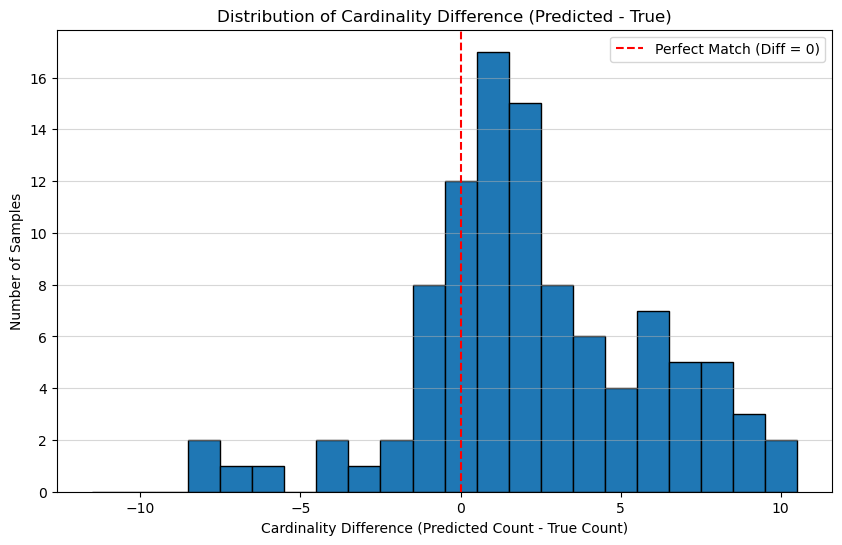

In [59]:
cardinality_true = np.sum(y_test_transformed, axis=1)
cardinality_pred = np.sum(y_pred_test, axis=1)
cardinality_difference = cardinality_pred - cardinality_true

max_abs_diff = np.abs(cardinality_difference).max()
bins = np.arange(-max_abs_diff, max_abs_diff + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(
    cardinality_difference,
    bins=bins,
    edgecolor='black',
    align='left'
)

plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match (Diff = 0)')

plt.title('Distribution of Cardinality Difference (Predicted - True)')
plt.xlabel('Cardinality Difference (Predicted Count - True Count)')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


We had a decent number of predictions that were close but many that predicted too many labels, as we suspected. We could adjust the positive threshold higher to be more in line with true cardinality.

Next we will take a look at the cardinality distribution for true and predicted labels.

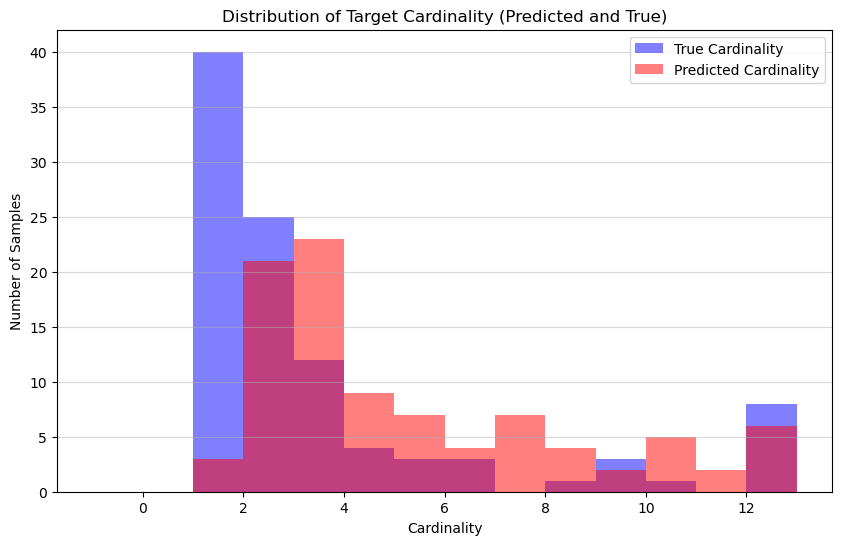

In [60]:
plt.figure(figsize=(10, 6))
bins = np.arange(
    -1,
    max(cardinality_true.max(), cardinality_pred.max()),
    1)

plt.hist(
    cardinality_true,
    bins=bins,
    alpha=0.5,
    color='blue',
    label='True Cardinality',
)
plt.hist(
    cardinality_pred,
    bins=bins,
    alpha=0.5,
    color='red',
    label='Predicted Cardinality'
)
plt.title('Distribution of Target Cardinality (Predicted and True)')
plt.xlabel('Cardinality')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

It looks like our model overpredicts the number of ESFs required at the low end and levels off a bit at the high end.

Next we will create heatmaps for incorrect and correct predictions, by label and type.

In [61]:
cm_array = multilabel_confusion_matrix(y_test_transformed, y_pred_test)

df_heatmap = pd.DataFrame({
    'True Positives': cm_array[:, 1, 1],
    'False Negatives': cm_array[:, 1, 0],
    'False Positives': cm_array[:, 0, 1],
    'True Negatives': cm_array[:, 0, 0]
})

df_heatmap.index = y_test_transformed.columns.tolist()

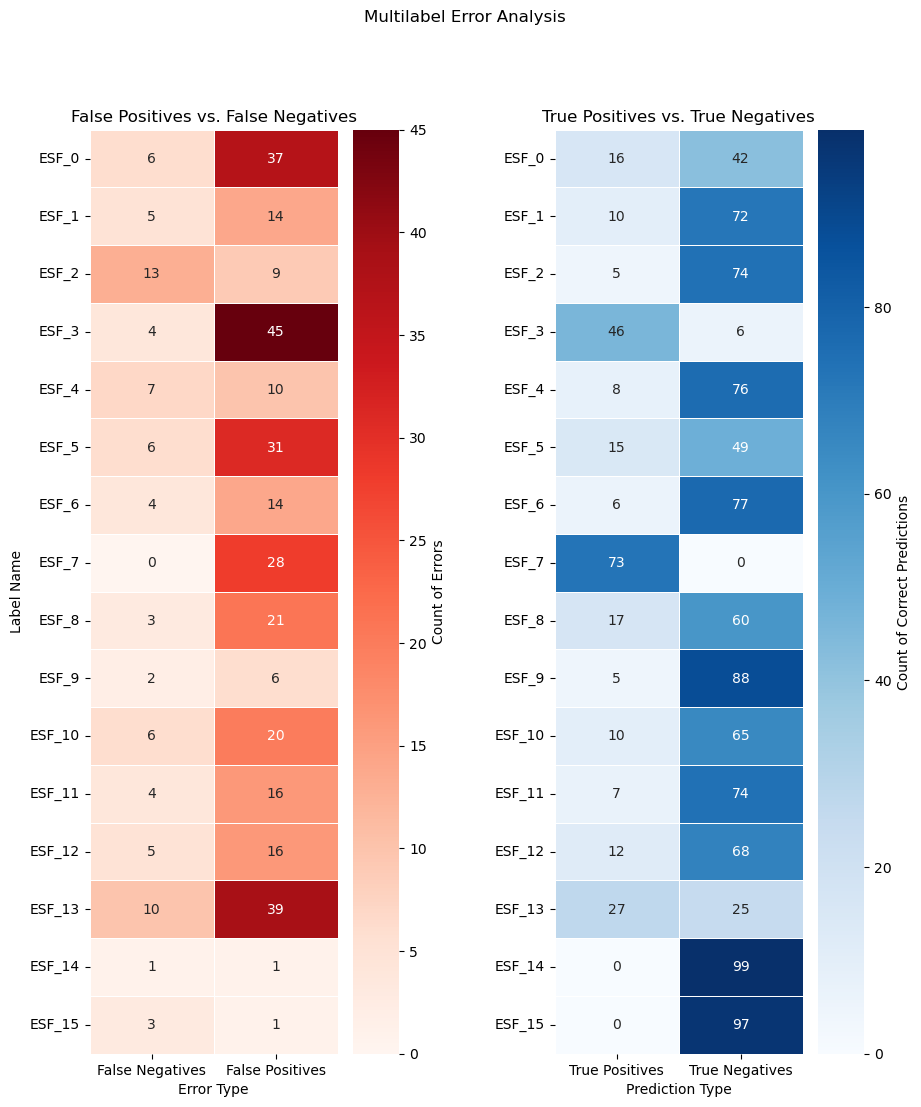

In [62]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 12), 
)

ax_errors = axes[0]
df_errors = df_heatmap[['False Negatives', 'False Positives']]

sns.heatmap(
    df_errors,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Errors'},
    ax = ax_errors,
)

ax_errors.set_title('False Positives vs. False Negatives')
ax_errors.set_ylabel('Label Name')
ax_errors.set_xlabel('Error Type')
current_labels = ax_errors.get_yticklabels()
ax_errors.set_yticklabels(
    current_labels,
    rotation=0,
)

ax_correct = axes[1]
df_correct = df_heatmap[['True Positives', 'True Negatives']]

sns.heatmap(
    df_correct,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Correct Predictions'},
    ax = ax_correct
)

ax_correct.set_title('True Positives vs. True Negatives')
ax_correct.set_xlabel('Prediction Type')
ax_correct.set_yticklabels(
    current_labels,
    rotation=0,
)

fig.suptitle('Multilabel Error Analysis')
plt.subplots_adjust(wspace=0.5)
plt.show()

Our model did well by not predicting too many false negatives but did a bad job with false positives. This reflects the earlier plots that pointed to excessive ESF predictions when the true values were much lower.

We will perform a label co-occurence analysis to determine label correlation differences between the test set and our predictions.

In [63]:
# Generate a matrix of label combination counts for the test set
labels = y_test_transformed.columns.tolist()
label_len = len(labels)
true_corr = np.dot(y_test_transformed.T, y_test_transformed)
co_occurrence_df = pd.DataFrame(
    true_corr,
    index=labels,
    columns=labels,
)
co_occurrence_df

,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,22,11,11,16,7,11,4,19,9,5,12,8,9,11,1,0
ESF_1,11,15,12,15,9,10,5,15,11,6,14,10,12,11,1,3
ESF_2,11,12,18,14,9,9,6,14,13,7,12,9,12,12,1,2
ESF_3,16,15,14,50,13,17,8,33,15,7,16,11,16,23,1,3
ESF_4,7,9,9,13,15,8,5,10,10,6,10,9,11,9,0,3
ESF_5,11,10,9,17,8,21,7,20,10,6,12,7,10,15,1,2
ESF_6,4,5,6,8,5,7,10,10,7,4,6,5,7,9,0,2
ESF_7,19,15,14,33,10,20,10,73,13,7,16,11,14,32,1,3
ESF_8,9,11,13,15,10,10,7,13,20,7,12,9,13,11,1,3
ESF_9,5,6,7,7,6,6,4,7,7,7,7,5,7,7,1,2


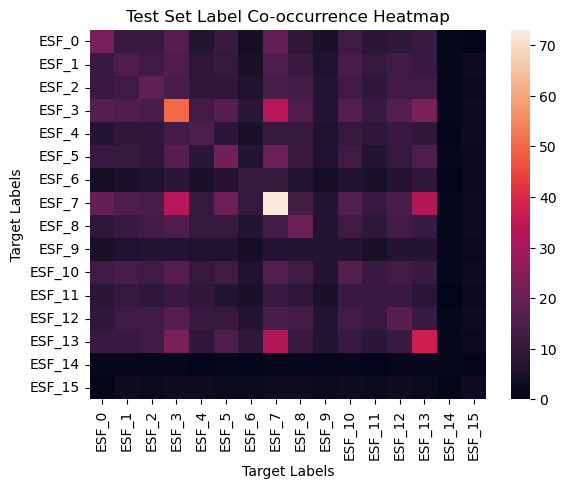

In [114]:
sns.heatmap(
    co_occurrence_df,
    annot=False,
    )
plt.title('Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

ESFs 7, 3, and 13 were very prevalant in the test set.

In [113]:
# Get a normalized version of the co-occurrence counts
label_counts = np.diag(co_occurrence_df)
normalized_co_occurrence_df = co_occurrence_df.div(
    label_counts,
    axis=0,
    )
normalized_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,1.000000,0.500000,0.500000,0.727273,0.318182,0.500000,0.181818,0.863636,0.409091,0.227273,0.545455,0.363636,0.409091,0.500000,0.045455,0.000000
ESF_1,0.733333,1.000000,0.800000,1.000000,0.600000,0.666667,0.333333,1.000000,0.733333,0.400000,0.933333,0.666667,0.800000,0.733333,0.066667,0.200000
ESF_2,0.611111,0.666667,1.000000,0.777778,0.500000,0.500000,0.333333,0.777778,0.722222,0.388889,0.666667,0.500000,0.666667,0.666667,0.055556,0.111111
ESF_3,0.320000,0.300000,0.280000,1.000000,0.260000,0.340000,0.160000,0.660000,0.300000,0.140000,0.320000,0.220000,0.320000,0.460000,0.020000,0.060000
ESF_4,0.466667,0.600000,0.600000,0.866667,1.000000,0.533333,0.333333,0.666667,0.666667,0.400000,0.666667,0.600000,0.733333,0.600000,0.000000,0.200000
ESF_5,0.523810,0.476190,0.428571,0.809524,0.380952,1.000000,0.333333,0.952381,0.476190,0.285714,0.571429,0.333333,0.476190,0.714286,0.047619,0.095238
ESF_6,0.400000,0.500000,0.600000,0.800000,0.500000,0.700000,1.000000,1.000000,0.700000,0.400000,0.600000,0.500000,0.700000,0.900000,0.000000,0.200000
ESF_7,0.260274,0.205479,0.191781,0.452055,0.136986,0.273973,0.136986,1.000000,0.178082,0.095890,0.219178,0.150685,0.191781,0.438356,0.013699,0.041096
ESF_8,0.450000,0.550000,0.650000,0.750000,0.500000,0.500000,0.350000,0.650000,1.000000,0.350000,0.600000,0.450000,0.650000,0.550000,0.050000,0.150000
ESF_9,0.714286,0.857143,1.000000,1.000000,0.857143,0.857143,0.571429,1.000000,1.000000,1.000000,1.000000,0.714286,1.000000,1.000000,0.142857,0.285714


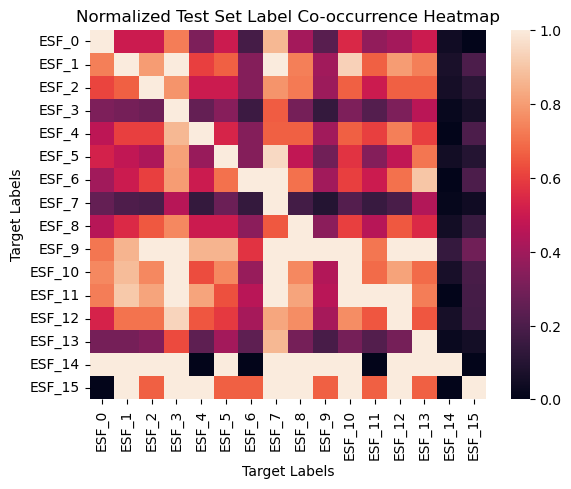

In [115]:
sns.heatmap(
    normalized_co_occurrence_df,
    annot=False,
    )
plt.title('Normalized Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

In [66]:
# Generate a matrix of label combination counts for the prediction set
pred_corr = np.dot(y_pred_test.T, y_pred_test)
pred_co_occurrence_df = pd.DataFrame(
    pred_corr,
    index=labels,
    columns=labels,
)

pred_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,53,23,12,51,17,33,18,53,32,11,27,20,24,38,1,1
ESF_1,23,24,13,24,18,21,16,24,24,11,23,20,18,22,0,1
ESF_2,12,13,14,14,11,13,9,14,13,8,13,11,12,14,0,1
ESF_3,51,24,14,91,18,45,20,91,38,11,30,23,28,62,1,1
ESF_4,17,18,11,18,18,16,13,18,18,11,17,18,15,18,0,1
ESF_5,33,21,13,45,16,46,19,46,33,10,25,20,25,38,0,1
ESF_6,18,16,9,20,13,19,20,20,17,8,19,17,10,19,0,1
ESF_7,53,24,14,91,18,46,20,101,38,11,30,23,28,66,1,1
ESF_8,32,24,13,38,18,33,17,38,38,11,26,21,28,36,1,1
ESF_9,11,11,8,11,11,10,8,11,11,11,10,11,10,11,0,1


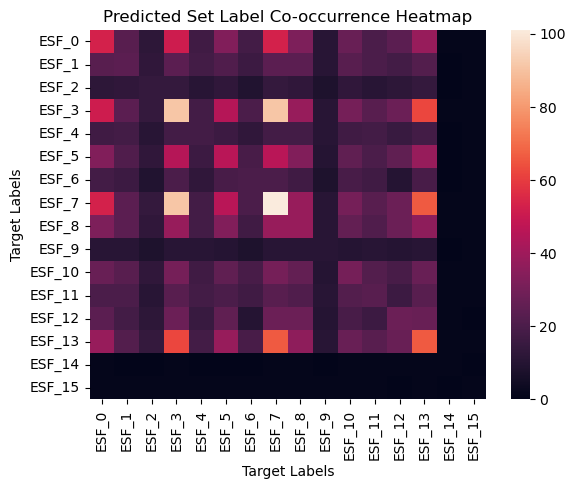

In [116]:
sns.heatmap(
    pred_co_occurrence_df,
    annot=False,
    )
plt.title('Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

ESFs 3, 7, and 13 were again prevalent in the predicted set, just at too high a rate.

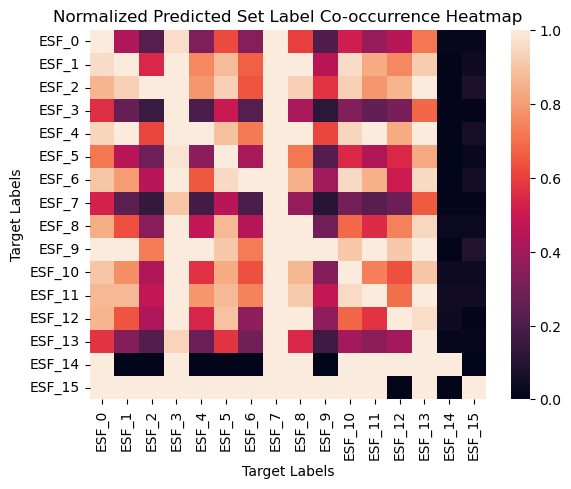

In [117]:
pred_label_counts = np.diag(pred_co_occurrence_df)
normalized_pred_co_occurrence_df = pred_co_occurrence_df.div(
    pred_label_counts,
    axis=0,
    )
sns.heatmap(
    normalized_pred_co_occurrence_df,
    annot=False,
    )
plt.title('Normalized Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

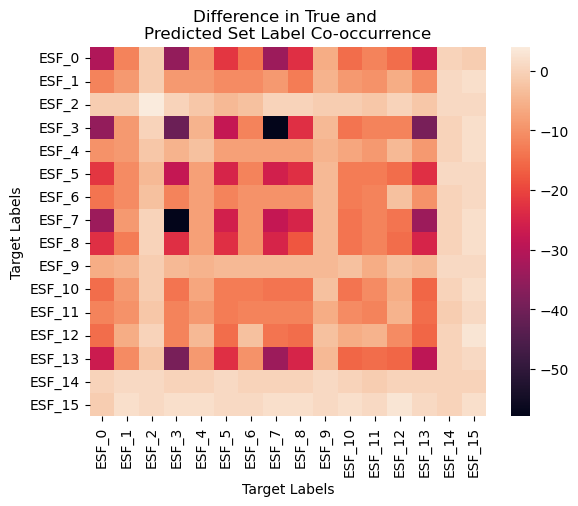

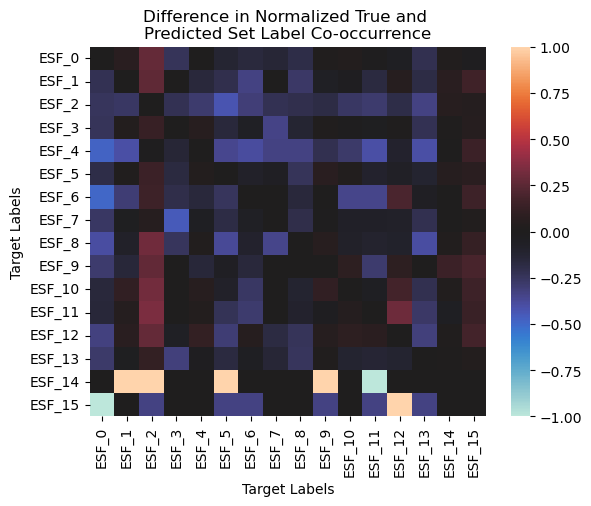

In [68]:
# Compare the differences between the test set and the prediction set

difference_df = co_occurrence_df - pred_co_occurrence_df
sns.heatmap(
    difference_df,
)
plt.title('Difference in True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

norm_difference_df = normalized_co_occurrence_df - normalized_pred_co_occurrence_df
sns.heatmap(
    norm_difference_df,
    center=0
)
plt.title('Difference in Normalized True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

There are definitely combinations of target labels that were underpredicted, with the worst being ESFs 9 and 14. There were other combinations with ESF 14 that also did poorly, both with underpredictions and overpredictions. It appears that ESF 15 and ESF 0 was not a real combination in the test set but is one that was predicted. Overall, our worst performance was on rare events, such as when ESFs 14 and 15 are present, and some of the more frequently occurring ESFs such as 0 and 13, though we did reasonably well when ESFs 3 or 7 were present.

We will now create a dataframe consisting of the label combinations and the error between the test set and the prediction set. Negative values will be overpredictions and positive values will be underpredictions.

In [69]:
difference_stack = (difference_df.stack().reset_index(name='difference').query('level_0 != level_1'))
largest_errors = difference_stack.reindex(difference_stack['difference'].abs().sort_values(ascending=False).index)
largest_errors.head(25)

,level_0,level_1,difference
115,ESF_7,ESF_3,-58
55,ESF_3,ESF_7,-58
61,ESF_3,ESF_13,-39
211,ESF_13,ESF_3,-39
3,ESF_0,ESF_3,-35
48,ESF_3,ESF_0,-35
215,ESF_13,ESF_7,-34
125,ESF_7,ESF_13,-34
7,ESF_0,ESF_7,-34
112,ESF_7,ESF_0,-34


We will also review combinations that worked well for the model by looking at the combinations in the tail.

In [70]:
largest_errors.tail(30)

,level_0,level_1,difference
95,ESF_5,ESF_15,1
42,ESF_2,ESF_10,-1
114,ESF_7,ESF_2,0
110,ESF_6,ESF_14,0
78,ESF_4,ESF_14,0
239,ESF_14,ESF_15,0
237,ESF_14,ESF_13,0
236,ESF_14,ESF_12,0
234,ESF_14,ESF_10,0
126,ESF_7,ESF_14,0


Many of our best and worst performances were on rare events, such as when ESFs 14 and/or 15 are present. Commonly occurring combinations, such as 3 and 7 or 3 and 13 were overpredicted by the model.

Let's compare it to the differences in the normalized sets.

In [71]:
normalized_difference_stack = (normalized_co_occurrence_df.stack().reset_index(name='difference').query('level_0 != level_1'))
normalized_largest_errors = normalized_difference_stack.reindex(normalized_difference_stack['difference'].abs().sort_values(ascending=False).index)
normalized_largest_errors.head(30)

,level_0,level_1,difference
154,ESF_9,ESF_10,1.0
237,ESF_14,ESF_13,1.0
224,ESF_14,ESF_0,1.0
23,ESF_1,ESF_7,1.0
225,ESF_14,ESF_1,1.0
244,ESF_15,ESF_4,1.0
226,ESF_14,ESF_2,1.0
227,ESF_14,ESF_3,1.0
229,ESF_14,ESF_5,1.0
243,ESF_15,ESF_3,1.0


In [72]:
normalized_largest_errors.tail(15)

,level_0,level_1,difference
14,ESF_0,ESF_14,0.045455
127,ESF_7,ESF_15,0.041096
222,ESF_13,ESF_14,0.027027
62,ESF_3,ESF_14,0.020000
126,ESF_7,ESF_14,0.013699
78,ESF_4,ESF_14,0.000000
110,ESF_6,ESF_14,0.000000
190,ESF_11,ESF_14,0.000000
235,ESF_14,ESF_11,0.000000
15,ESF_0,ESF_15,0.000000


In [122]:
largest_errors[(largest_errors['level_0']=='ESF_15')&(
    largest_errors['level_1']=='ESF_3'
)]

,level_0,level_1,difference
243,ESF_15,ESF_3,2


In [106]:
largest_errors[(largest_errors['level_0']=='ESF_9')&(
    largest_errors['level_1']=='ESF_10'
)]

,level_0,level_1,difference
154,ESF_9,ESF_10,-3


In [123]:
largest_errors[(largest_errors['level_0']=='ESF_1')&(
    largest_errors['level_1']=='ESF_7'
)]

,level_0,level_1,difference
23,ESF_1,ESF_7,-9


In [124]:
largest_errors[(largest_errors['level_0']=='ESF_9')&(
    largest_errors['level_1']=='ESF_3'
)]

,level_0,level_1,difference
147,ESF_9,ESF_3,-4


In [125]:
largest_errors[(largest_errors['level_0']=='ESF_9')&(
    largest_errors['level_1']=='ESF_12'
)]

,level_0,level_1,difference
156,ESF_9,ESF_12,-3


There are some combinations that we predicted very often that did have multiple incorrect instances, such as ESFs 3 and 7, that we were wrong about a majority of the time but not every time. A quick check of those incorrect all of the time showed that the combination could be rarely used (just two to four times for some) but not always (nine times for ESFs 1 and 7).

Next we will look at permutation importance across the feature groups.

In [78]:

groups = {
    'state': state_columns,
    'region': region_columns,
    'declarationType': declaration_columns,
    'designatedIncidentTypes': type_columns
}

def grouped_feature_permutation(
    model,
    X,
    y,
    groups,
    metric_,
):
    baseline = combined_score(y_true=y, y_pred=model.predict(X = X))
    group_importance = {}
    group_importance['baseline'] = baseline
    for group, columns in groups.items():
        score_changes = []
        rng = np.random.default_rng(seed = random_state)
        for i in range(1,11):
            X_perm = X.copy()
            shuffled_ind = rng.permutation(X.index)
            X_perm[columns] = X_perm[columns].values[shuffled_ind]
            perm_score = combined_score(y_true= y, y_pred=model.predict(X_perm),)
            score_changes.append(perm_score)
        group_importance[group] = (f'Mean: {np.mean(score_changes)}', #Mean
                                   f'Max: {np.max(score_changes)}', #Max
                                   f'Min: {np.min(score_changes)}', #Min
                                   f'Std: {np.std(score_changes)}') #Std
    labels = []
    means = []
    errors = []

    for key, value in group_importance.items():
        if key == "baseline":
            y_line = (value)
        else:
            mean_val = float(value[0].split(":")[1])
            std_val = float(value[3].split(":")[1])
            labels.append(key)
            means.append(mean_val)
            errors.append(std_val)
    # Create a plot of values
    plt.figure(figsize=(10,6))
    plt.bar(labels,
            means,
            yerr=errors)
    plt.axhline(y=y_line,
                color='k',
                linestyle='--',
                label='Baseline',
                )
    plt.ylim([0, 1.5])
    plt.ylabel('Combined Metric Score')
    plt.title('Performance Given Permuted Values of Feature Groups')
    plt.tight_layout()
    plt.show()

    return group_importance

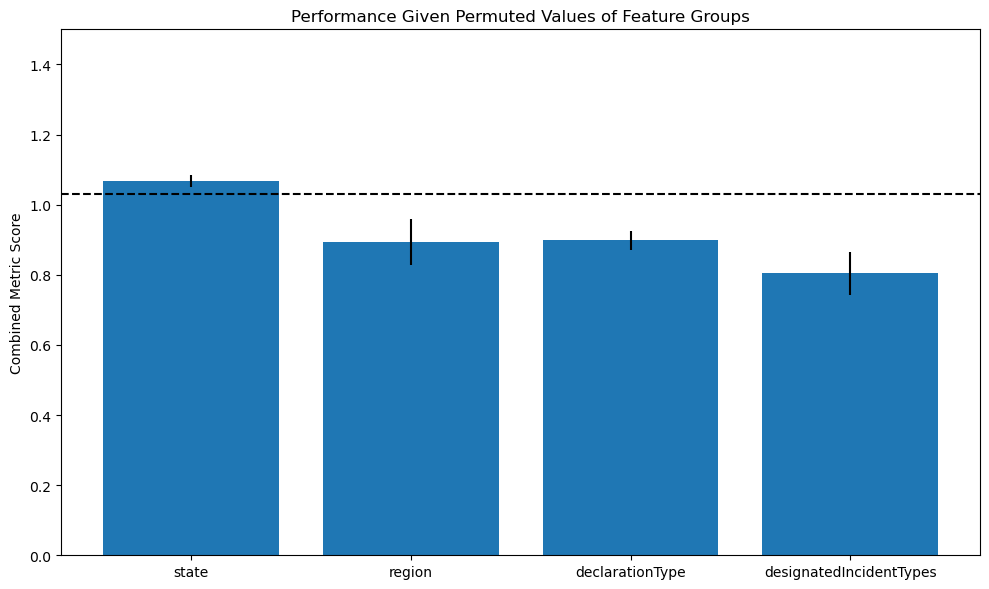

{'baseline': 1.0300039507424754,
 'state': ('Mean: 1.0676440019720896',
  'Max: 1.094512282132748',
  'Min: 1.03281926198506',
  'Std: 0.01711154911486252'),
 'region': ('Mean: 0.8934259687151844',
  'Max: 1.0505911059892017',
  'Min: 0.8146662399120104',
  'Std: 0.0648909586227842'),
 'declarationType': ('Mean: 0.8986895918192583',
  'Max: 0.9385659766830285',
  'Min: 0.8578041341596541',
  'Std: 0.02689237128640287'),
 'designatedIncidentTypes': ('Mean: 0.8040636797833164',
  'Max: 0.8872680305698337',
  'Min: 0.7061483282182511',
  'Std: 0.060495838912356076')}

In [79]:
perm_scores = grouped_feature_permutation(study_ovrxgb_tuned,
                                          X_test_transformed,
                                          y_test_transformed,
                                          groups,
                                          F1_Macro_Avg)

perm_scores

Permutations of state actually seem to have improved the results over the baseline ever so slightly, whereas every other group results in lower scores. Changing the designatedIncidentTypes has the biggest negative impact on the final metric score compared to the baseline.

Let us start analyzing edge cases. We can begin by picking a few rows from the same incident and comparing outcomes for different states.

In [80]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2023081703     3
2021081902     3
2018031201     2
2024042701     2
2024052402     2
2024080901     2
2023030901     2
2022122101     2
2021081801     2
2020041101     2
2020010701     2
2016100501     1
2023081101     1
2014061802     1
2021080901     1
2021062401     1
2014020501     1
2022081903     1
2022070501     1
2022051202     1
2022062801     1
2023030102     1
2013060301     1
2013051001     1
2016061101     1
2023081801     1
2023082901     1
2023090401     1
2024080603     1
2013050601     1
2013062801     1
2024082001     1
2024042902     1
2024042901     1
2013070101     1
2014071703     1
2022010701     1
2015021101     1
2022010301     1
2016081301     1
2016092301     1
2017012001     1
2017021001     1
2017031101     1
2017052601     1
2017072901     1
2017110601     1
2017110602     1
2018082801     1
2018041602     1
2016100502     1
2018022302     1
2019101801     1
2019110101     1
2019110801     1
201

In [81]:
X_test[X_test['incidentId']==2012102505]

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0
5,2012102505,MD,[Hurricane],EM,3,2012.0
6,2012102505,NJ,[Hurricane],DR,2,2012.0
7,2012102505,NY,[Hurricane],DR,2,2012.0
8,2012102505,PA,[Hurricane],EM,3,2012.0
9,2012102505,RI,[Hurricane],DR,1,2012.0


In [82]:
compare_true_to_pred(8, X_test, y_test_transformed, y_pred_test)

incidentId                  2012102505
state                               PA
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 8, dtype: object 
         true  predicted
ESF_0      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_12     0          1
ESF_13     0          1 
        true  predicted
ESF_3     1          1
ESF_8     1          1


In [83]:
compare_true_to_pred(1, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               DC
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 1, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_8      0          1
ESF_12     0          1
ESF_13     0          1 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [84]:
compare_true_to_pred(5, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 5, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_8      0          1
ESF_12     0          1
ESF_13     0          1 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [85]:
compare_true_to_pred(0, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               CT
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               1
year                            2012.0
Name: 0, dtype: object 
         true  predicted
ESF_1      1          0
ESF_4      1          0
ESF_8      1          0
ESF_10     1          0
ESF_11     1          0
ESF_12     1          0
ESF_13     0          1
ESF_15     1          0 
        true  predicted
ESF_3     1          1
ESF_7     1          1


In [86]:
compare_true_to_pred(10, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               VA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 10, dtype: object 
         true  predicted
ESF_2      0          1
ESF_3      0          1
ESF_5      0          1
ESF_13     0          1 
        true  predicted
ESF_7     1          1


Here we see five match incidentId values with matching designatedIncidentTypes across five different states with varying declarationTypes. This helps show some of the difficulties in predicting ESFs based on very few features. The disaster in Connecticut varies from the disaster in Virginia only by state, but the incident in Connecticut required nine different ESFs while in Virginia is only required one. It is interesting that the event in Connecticut did not result in nearly as many positive predicted labels as the incident in Virgina. Had those been flipped, our outcomes would have improved in both locations.

Lets look at some of the incidents in the test set with large label sets to see how we performed in those cases.

In [87]:
label_set_counts_true = y_test_transformed.sum(axis=1)
edge_cases_large_label_sets = label_set_counts_true.sort_values()
edge_cases_large_label_sets[-10:]

28    10
89    12
46    12
66    13
81    13
52    13
6     13
73    13
64    13
7     14
dtype: int64

In [88]:
compare_true_to_pred(7, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               NY
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               2
year                            2012.0
Name: 7, dtype: object 
         true  predicted
ESF_0      0          1
ESF_15     1          0 
         true  predicted
ESF_1      1          1
ESF_2      1          1
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_6      1          1
ESF_7      1          1
ESF_8      1          1
ESF_9      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [89]:
compare_true_to_pred(64, X_test, y_test_transformed, y_pred_test)


incidentId                  2021082601
state                               LA
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               6
year                            2021.0
Name: 65, dtype: object 
        true  predicted
ESF_2     1          0
ESF_5     0          1
ESF_6     1          0 
         true  predicted
ESF_0      1          1
ESF_1      1          1
ESF_3      1          1
ESF_4      1          1
ESF_7      1          1
ESF_8      1          1
ESF_9      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [90]:
compare_true_to_pred(81, X_test, y_test_transformed, y_pred_test)


incidentId                                                      2023030901
state                                                                   CA
designatedIncidentTypes    [Flood, Snowstorm, Severe Storm, Mud/Landslide]
declarationType                                                         EM
region                                                                   9
year                                                                2023.0
Name: 81, dtype: object 
        true  predicted
ESF_6     0          1 
         true  predicted
ESF_0      1          1
ESF_1      1          1
ESF_2      1          1
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_7      1          1
ESF_8      1          1
ESF_9      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [91]:
compare_true_to_pred(50, X_test, y_test_transformed, y_pred_test)


incidentId                  2020091301
state                               FL
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               4
year                            2020.0
Name: 54, dtype: object 
         true  predicted
ESF_1      0          1
ESF_2      0          1
ESF_3      0          1
ESF_4      0          1
ESF_6      0          1
ESF_8      0          1
ESF_9      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1
ESF_15     0          1 
        true  predicted
ESF_0     1          1
ESF_5     1          1
ESF_7     1          1


In [92]:
compare_true_to_pred(26, X_test, y_test_transformed, y_pred_test)


incidentId                 2016100501
state                              WI
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              5
year                           2016.0
Name: 28, dtype: object 
        true  predicted
ESF_3     0          1 
         true  predicted
ESF_7      1          1
ESF_13     1          1


We did fairly well on the large datasets. Our worst performance involved a hurricane in Florida, which could easily have been a combination in the training set. Perhaps there were other hurricanes or disasters in Florida that required more ESFs.

Let's look for instances with the worst differences in cardinality, skipping some that we have already viewed.

In [93]:
label_set_counts_pred = y_pred_test.sum(axis=1)
label_set_counts_true-label_set_counts_pred


0       6
1      -6
2      -3
3      -6
4      -3
5      -6
6      -1
7       0
8      -4
9       0
10     -4
11     -4
12     -5
13     -2
14     -2
15     -2
16     -6
17     -2
18     -1
19     -7
20     -3
21     -8
22     -1
23      0
24      1
25     -1
26     -1
27     -1
28      8
29     -6
30     -2
31     -1
32     -1
33     -1
34      0
35     -1
36     -3
37      0
38     -5
39     -1
40      0
41      1
42     -7
43     -1
44     -2
45      4
46      4
47     -8
48     -3
49     -6
50    -11
51     -2
52      1
53      2
54     -1
55      1
56     -2
57      0
58     -3
59     -4
60     -9
61     -3
62     -9
63     -2
64      1
65      0
66      8
67     -5
68     -5
69     -2
70     -4
71     -6
72     -7
73     -1
74     -2
75     -2
76     -2
77     -1
78      1
79      0
80     -7
81     -1
82     -8
83     -1
84     -8
85     -8
86     -9
87     -2
88    -11
89      7
90     -2
91     -4
92     -7
93      0
94     -3
95      1
96      0
97      3
98      2
99      1


He is one from the large label set series above that we did not check. 

In [127]:
compare_true_to_pred(21, X_test, y_test_transformed, y_pred_test)


incidentId                 2014071703
state                              WA
designatedIncidentTypes        [Fire]
declarationType                    EM
region                             10
year                           2014.0
Name: 21, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      0          1
ESF_7      0          1
ESF_8      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1 
         true  predicted
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_12     1          1


Interesting. It is a fire in Washington for which we predicted many unnecessary ESFs were actually necessary. Fires can be of different scales and be limited to areas with smaller populations.

Now we can look at some of the worst overpredictions.

In [128]:
compare_true_to_pred(62, X_test, y_test_transformed, y_pred_test)


incidentId                  2021082601
state                               NJ
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               2
year                            2021.0
Name: 67, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      0          1
ESF_4      0          1
ESF_8      0          1
ESF_9      0          1
ESF_10     0          1
ESF_11     0          1
ESF_12     0          1 
         true  predicted
ESF_3      1          1
ESF_5      1          1
ESF_6      1          1
ESF_7      1          1
ESF_13     1          1


In [96]:
compare_true_to_pred(88, X_test, y_test_transformed, y_pred_test)


incidentId                    2023082901
state                                 WA
designatedIncidentTypes    [Other, Fire]
declarationType                       DR
region                                10
year                              2023.0
Name: 88, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      0          1
ESF_3      0          1
ESF_4      0          1
ESF_5      0          1
ESF_6      0          1
ESF_8      0          1
ESF_10     0          1
ESF_11     0          1
ESF_12     0          1 
         true  predicted
ESF_7      1          1
ESF_13     1          1


Here we see a hurricane in a coastal state and another fire in Washington that generated very few ESFs in reality but our model predicts the need for many more.

We will round out our error analysis by checking predictions with the worst and best Jaccard similarity scores.

In [97]:
# Calculate Jaccard similarity between the test set and the prediction set by row.

jaccard_series = pd.Series(
    [
        jaccard_score(y_test_transformed.iloc[i], y_pred_test[i], average='macro')
        for i in range(len(y_test_transformed))
    ],
    index=y_test_transformed.index
)
jaccard_series.sort_values()


86     0.175000
50     0.184066
88     0.184066
85     0.212121
84     0.212121
1      0.250000
3      0.250000
5      0.250000
62     0.269481
60     0.269481
82     0.314286
47     0.314286
28     0.314286
0      0.314286
49     0.328671
66     0.328671
92     0.329167
21     0.333333
48     0.343750
80     0.361111
12     0.361111
42     0.361111
16     0.371429
29     0.371429
72     0.380769
19     0.380769
89     0.390152
35     0.406250
41     0.406250
71     0.410714
8      0.410714
38     0.416667
67     0.416667
27     0.416667
70     0.435897
79     0.437500
68     0.464286
61     0.464286
91     0.466667
10     0.466667
11     0.466667
59     0.523810
36     0.525000
94     0.525000
20     0.525000
2      0.525000
4      0.525000
6      0.525000
46     0.583333
69     0.583333
64     0.592857
58     0.592857
45     0.595960
87     0.600000
74     0.600000
90     0.600000
7      0.600000
93     0.600000
75     0.600000
65     0.600000
76     0.600000
14     0.600000
100    0

In [129]:
compare_true_to_pred(86, X_test, y_test_transformed, y_pred_test)


incidentId                                                        2023081703
state                                                                     CA
designatedIncidentTypes    [Hurricane, Tropical Storm, Severe Storm, Floo...
declarationType                                                           DR
region                                                                     9
year                                                                  2023.0
Name: 86, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      1          0
ESF_3      0          1
ESF_4      0          1
ESF_5      0          1
ESF_6      0          1
ESF_7      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1 
        true  predicted
ESF_8     1          1


In [136]:
compare_true_to_pred(85, X_test, y_test_transformed, y_pred_test)


incidentId                                             2023081703
state                                                          CA
designatedIncidentTypes    [Flood, Mud/Landslide, Tropical Storm]
declarationType                                                DR
region                                                          9
year                                                       2023.0
Name: 85, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      1          0
ESF_3      0          1
ESF_5      0          1
ESF_6      0          1
ESF_7      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1 
        true  predicted
ESF_8     1          1


The first two are California floods with additional incident types. This could be an issue of an updated MA appearing in the dataset for the same disaster, which does happen occasionally and can make automated methods of gathering and grouping data less than ideal. The addition of extra incident types prompted the model to add ESF 4 to the prediction set, which was also incorrect.

In [138]:
compare_true_to_pred(47, X_test, y_test_transformed, y_pred_test)


incidentId                  2020091301
state                               FL
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               4
year                            2020.0
Name: 53, dtype: object 
         true  predicted
ESF_2      0          1
ESF_4      0          1
ESF_6      0          1
ESF_8      0          1
ESF_9      0          1
ESF_11     0          1
ESF_12     0          1
ESF_13     0          1 
         true  predicted
ESF_0      1          1
ESF_1      1          1
ESF_3      1          1
ESF_5      1          1
ESF_7      1          1
ESF_10     1          1


In [139]:
compare_true_to_pred(28, X_test, y_test_transformed, y_pred_test)


incidentId                 2016081301
state                              LA
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              6
year                           2016.0
Name: 26, dtype: object 
         true  predicted
ESF_1      1          0
ESF_5      1          0
ESF_6      1          0
ESF_8      1          0
ESF_10     1          0
ESF_11     1          0
ESF_12     1          0
ESF_13     1          0 
        true  predicted
ESF_3     1          1
ESF_7     1          1


These last two again have designatedIncidentTypes that would signify need for significant support according to the model but in reality did not require many Emergency Support Functions at all. There appears to be a feature missing that would indicate severity of the incident in a more nuanced way than declarationType provides.

We will finish by looking at our best performances.

In [142]:
compare_true_to_pred(40, X_test, y_test_transformed, y_pred_test)


incidentId                 2018022302
state                              IN
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              5
year                           2018.0
Name: 37, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
         true  predicted
ESF_3      1          1
ESF_7      1          1
ESF_13     1          1


In [143]:
compare_true_to_pred(96, X_test, y_test_transformed, y_pred_test)


incidentId                 2024042901
state                              NE
designatedIncidentTypes     [Tornado]
declarationType                    DR
region                              7
year                           2024.0
Name: 92, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
        true  predicted
ESF_5     1          1
ESF_7     1          1


In [140]:
compare_true_to_pred(57, X_test, y_test_transformed, y_pred_test)


incidentId                     2022010301
state                                  KS
designatedIncidentTypes    [Severe Storm]
declarationType                        DR
region                                  7
year                               2021.0
Name: 72, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
        true  predicted
ESF_7     1          1


In [105]:
compare_true_to_pred(34, X_test, y_test_transformed, y_pred_test)


incidentId                     2017072901
state                                  WV
designatedIncidentTypes    [Severe Storm]
declarationType                        DR
region                                  3
year                               2017.0
Name: 34, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
         true  predicted
ESF_7      1          1
ESF_13     1          1


Very interesting. We did well on a flood in Indiana but also performed very poorly on a flood in Louisiana. We also did well on two severe storms even though they required different ESFs between the two incidents. We also managed to accurately predict ESFs needed for a tornado, which can vary in severity and impact tremendously.

It appears that we can handle some incidents well but a lack of training data is the likely culprit.